En este cuaderno vamos a hacer un primer ensemble. <br>
La idea es tener una función que genere modelos entrenados LGBM, LSTM, RF y XGBoost. <br>
Luego otra función combina las predicciones de los 4 modelos en una sola predicción, tomando un promedio ponderado en base a las RMSE obtenidas.

Aclaramos que no consideraremos el uso de SARIMAX ya que las predicciones son bastante pobres a partir del 2 día luego de la solicitud, por lo que no será de utilidad. Esto se volverá a considerar posteriormente con el entrenamiento con más datos. Además, si el cliente decide implementar este sistema y consigue la demanda actualizada al día de la fecha, puede incluirse SARIMAX con mejores resultados.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
sns.set_theme()
import holidays
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.optimizers import Adam
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_squared_error
from scikeras.wrappers import KerasRegressor
from keras.initializers import HeNormal
from datetime import datetime, timedelta
import openmeteo_requests
import requests_cache
from retry_requests import retry
from joblib import dump, load

In [3]:
np.random.seed(42)

Cargamos el dataframe para pruebas

In [4]:
df = pd.read_parquet('../data_export/prueba_ml.parquet')
df.reset_index(inplace=True, drop=True)
df['dia_semana'] = df['fecha'].dt.weekday + 1
year = 2023
us_holidays = holidays.US(years=year)
us_holidays
df['holiday'] = np.where(df['fecha'].isin(us_holidays), 1, 0)
df['rain'] = df['rain'].shift(1)
df['snowfall'] = df['snowfall'].shift(1)
df.fillna(0.0, inplace=True)
df['datetime'] = pd.to_datetime(df['fecha'].astype(str) + ' ' + df['hora'].astype(int).astype(str) + ':00:00')
df.drop(columns='fecha', inplace=True)
df.set_index('datetime', inplace=True)
columnas_X = ['año', 'mes', 'dia', 'hora', 'dia_semana', 'holiday', 'temperature_2m', 'rain', 'relative_humidity_2m', 'snowfall']
X = df[columnas_X]
columnas_Y= ['Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island']
Y = df[columnas_Y]

Funciones para LSTM

In [5]:
def generador_X_Y(X, Y, p=5):
    ''' 
    A partir dos dataframes, X e Y, y los pasos de tiempo, retorna un tensor 3D para X y una array 2D para Y.
    args:
    - X: pandas dataframe, con m filas (muestras) y n columnas (features)
    - Y: pandas dataframe, con m filas (muestras) e y columnas (longitud de vector de respuesta)
    - p (int): número de pasos de tiempo a considerar
    returns:
    - X_reshaped: numpy array de forma (m, p, n)
    - Y_reshaped: numpy array de forma (m, y)
    '''
    
    X_reshaped_list = list()
    Y_rehaped_list = list()

    m = len(X)
    X = np.array(X)
    Y = np.array(Y)

    for i in range(m-p):
        X_reshaped_list.append(X[i:i+p, :])
        Y_rehaped_list.append(Y[i+p-1, :])
    
    X_reshaped = np.array(X_reshaped_list)
    Y_reshaped = np.array(Y_rehaped_list)

    return X_reshaped, Y_reshaped

def crear_modelo(X_reshaped, Y_reshaped, nro_capas_lstm=1, unidades_capa= [50], nro_capas_dense=0, unidades_dense=[0], loss_= 'mse', 
                 act_salida='linear', act_lstm= 'relu', drop_out= 0, learning_r=0.001, act_dense= 'linear'):
    '''
    Crea un modelo de red neuronal recurrente (RNN) utilizando la arquitectura de Long Short-Term Memory (LSTM) para tareas de aprendizaje automático, como la predicción de series temporales.

    Argumentos:
    - X_reshaped: Array numpy que contiene los datos de entrada con la forma (número de muestras, número de pasos de tiempo, número de características). Representa las secuencias de entrada al modelo.
    - Y_reshaped: Array numpy que contiene los datos de salida esperados con la forma (número de muestras, número de características). Representa las etiquetas correspondientes a las secuencias de entrada.
    - nro_capas_lstm: Número entero que indica la cantidad de capas LSTM que se deben agregar al modelo. Por defecto, se establece en 1.
    - unidades_capa: Lista de enteros que especifica el número de unidades en cada capa LSTM. Cada elemento de la lista corresponde al número de unidades en una capa LSTM particular. Por defecto, se establece en [50].
    - nro_capas_dense: Número entero que indica la cantidad de capas densas que se deben agregar al modelo después de las capas LSTM. Por defecto, se establece en 0.
    - unidades_dense: Lista de enteros que especifica el número de unidades en cada capa densa. Cada elemento de la lista corresponde al número de unidades en una capa densa particular. Por defecto, se establece en [0].
    - loss_: Cadena que indica la función de pérdida a utilizar durante el entrenamiento del modelo. Por defecto, se establece en 'mse' (Mean Squared Error).
    - act_salida: Cadena que especifica la función de activación a utilizar en la capa de salida del modelo. Por defecto, se establece en 'linear'.
    - act_lstm: Cadena que indica la función de activación a utilizar en las capas LSTM del modelo. Por defecto, se establece en 'relu'.
    - drop_out: Valor flotante que representa la tasa de abandono para las capas Dropout, utilizadas para regularizar el modelo y prevenir el sobreajuste. Por defecto, se establece en 0.
    - learning_r: Valor flotante que indica la tasa de aprendizaje del optimizador Adam utilizado para entrenar el modelo. Por defecto, se establece en 0.001.
    - act_dense: Cadena que especifica la función de activación a utilizar en las capas densas del modelo. Por defecto, se establece en 'linear'.

    Devuelve:
    - model: Modelo secuencial de Keras configurado de acuerdo a los parámetros especificados.

    '''

    # Construimos el modelo LSTM
    model = Sequential()
    if nro_capas_lstm > 1:

        model.add(LSTM(units=unidades_capa[0], activation=act_lstm, input_shape=(X_reshaped.shape[1], X_reshaped.shape[2]), return_sequences=True))
        model.add(Dropout(drop_out))
        for i in range(1, nro_capas_lstm-1):
            model.add(LSTM(units=unidades_capa[i], activation=act_lstm, return_sequences=True))
            model.add(Dropout(drop_out))
        model.add(LSTM(units=unidades_capa[-1], activation=act_lstm))
 

    if nro_capas_lstm == 1:
        model.add(LSTM(units=unidades_capa[0], activation=act_lstm, input_shape=(X_reshaped.shape[1], X_reshaped.shape[2])))
        model.add(Dropout(drop_out))
    
    if nro_capas_dense > 0:
        for i in range(nro_capas_dense):
            model.add(Dense(units=unidades_dense[i], activation=act_dense, kernel_initializer=HeNormal()))
    
    model.add(Dense(units=Y_reshaped.shape[1], activation=act_salida, kernel_initializer=HeNormal() ))

    opt = Adam(learning_rate=learning_r)

    model.compile(optimizer=opt, loss=loss_)  # Compilación del modelo 

    return model

def construir_modelo_cv_lstm(X, Y, nro_pasos=5, nro_capas_lstm=2, unidades_capa= [50,40], loss_= 'mse', act_salida='relu', act_lstm= 'relu', 
                     epochs= 300, batch= 32, drop_out= 0, scaler= 'minmax', learning_r=0.0001, nro_capas_dense=0, unidades_dense=[0], 
                     act_dense= 'linear', verbose=0):
    '''
    Construye y entrena un modelo de red neuronal utilizando la técnica de validación cruzada en series temporales.

    Argumentos:
    - X: Array numpy que contiene los datos de entrada.
    - Y: Array numpy que contiene los datos de salida.
    - nro_pasos: Número entero que indica la cantidad de pasos de tiempo a considerar para la secuencia de entrada. Por defecto, se establece en 10.
    - nro_capas_lstm: Número entero que indica la cantidad de capas LSTM que se deben agregar al modelo. Por defecto, se establece en 1.
    - unidades_capa: Lista de enteros que especifica el número de unidades en cada capa LSTM. Cada elemento de la lista corresponde al número de unidades en una capa LSTM particular. Por defecto, se establece en [50].
    - loss_: Cadena que indica la función de pérdida a utilizar durante el entrenamiento del modelo. Por defecto, se establece en 'mse' (Mean Squared Error).
    - act_salida: Cadena que especifica la función de activación a utilizar en la capa de salida del modelo. Por defecto, se establece en 'linear'.
    - act_lstm: Cadena que indica la función de activación a utilizar en las capas LSTM del modelo. Por defecto, se establece en 'relu'.
    - epochs: Número entero que indica la cantidad de épocas de entrenamiento. Por defecto, se establece en 50.
    - batch: Número entero que indica el tamaño del lote durante el entrenamiento. Por defecto, se establece en 32.
    - drop_out: Valor flotante que representa la tasa de abandono para las capas Dropout, utilizadas para regularizar el modelo y prevenir el sobreajuste. Por defecto, se establece en 0.
    - scaler: Cadena que indica el método de escalado a aplicar a los datos. Puede ser 'minmax' para escalamiento Min-Max o 'standard' para escalamiento estándar. Por defecto, se establece en 'minmax'.
    - learning_r: Valor flotante que indica la tasa de aprendizaje del optimizador Adam utilizado para entrenar el modelo. Por defecto, se establece en 0.001.
    - nro_capas_dense: Número entero que indica la cantidad de capas densas que se deben agregar al modelo después de las capas LSTM. Por defecto, se establece en 0.
    - unidades_dense: Lista de enteros que especifica el número de unidades en cada capa densa. Cada elemento de la lista corresponde al número de unidades en una capa densa particular. Por defecto, se establece en [0].
    - act_dense: Cadena que especifica la función de activación a utilizar en las capas densas del modelo. Por defecto, se establece en 'linear'.

    Devuelve:
    - modelo: Modelo entrenado.
    - scaler_X: Objeto de la clase MinMaxScaler o StandardScaler utilizado para escalar los datos de entrada.
    - scaler_Y: Objeto de la clase MinMaxScaler o StandardScaler utilizado para escalar los datos de salida.
    - predictions: diccionario con las predicciones para cada distrito del set de testeo.
    - scores: Lista de puntajes de error cuadrático negativo obtenidos durante la validación cruzada.
    - history: Objeto que contiene el historial de entrenamiento del modelo.
    - loss: Valor de la pérdida final obtenido en el conjunto de pruebas.
    - rmse_dict = diccionario con los valores de RMSE en el set de testeo para cada distrito.
    '''
    if verbose==1:
        print('Inicio de construcción modelo LSTM')
    # Normalizar los datos
    if scaler == 'minmax':
        scaler_X = MinMaxScaler()
        scaler_Y = MinMaxScaler()
    if scaler == 'standard':
        scaler_X = StandardScaler()
        scaler_Y = StandardScaler()

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=False)

    X_train_scaled = scaler_X.fit_transform(X_train)
    Y_train_scaled = scaler_Y.fit_transform(Y_train)
    X_test_scaled = scaler_X.transform(X_test)
    Y_test_scaled = scaler_Y.transform(Y_test)

    # Reshape de los datos para que sean 3D (número de muestras, número de pasos de tiempo, número de características)
    X_train_reshaped, Y_train_reshaped = generador_X_Y(X_train_scaled, Y_train_scaled, nro_pasos)
    X_test_reshaped, Y_test_reshaped = generador_X_Y(X_test_scaled, Y_test_scaled, nro_pasos)

    # Envolvemos el modelo en un estimador de Scikit-Learn
    estimator = KerasRegressor(
        build_fn=crear_modelo,
        X_reshaped=X_train_reshaped,
        Y_reshaped=Y_train_reshaped,
        nro_capas_lstm=nro_capas_lstm,
        unidades_capa=unidades_capa,
        nro_capas_dense = nro_capas_dense,
        unidades_dense = unidades_dense,
        loss_=loss_,
        act_salida= act_salida,
        act_lstm= act_lstm,
        act_dense = act_dense,
        drop_out=drop_out,
        learning_r=learning_r,
        epochs=epochs,
        batch_size=batch,
        verbose=0
    )

    # Usamos el regresor en cross_val_score

    tscv = TimeSeriesSplit(n_splits=5)
    scores = cross_val_score(estimator, X_train_reshaped, Y_train_reshaped, cv=tscv, scoring='neg_mean_squared_error', verbose=0)

    # entrenamos el modelo

    modelo = crear_modelo(X_train_reshaped, Y_train_reshaped, nro_capas_lstm, unidades_capa, nro_capas_dense, unidades_dense, loss_, 
                    act_salida, act_lstm, drop_out, learning_r, act_dense)
    
    history = modelo.fit(X_train_reshaped, Y_train_reshaped, epochs=epochs, batch_size=batch, validation_data=(X_test_reshaped, Y_test_reshaped), verbose=0)

    if loss_ == 'mse':
        loss = modelo.evaluate(X_test_reshaped, Y_test_reshaped, verbose=verbose)
    else:
        y_pred = modelo.predict(X_test_reshaped)
        loss = np.mean(tf.keras.losses.mean_squared_error(Y_test_reshaped, y_pred).numpy())
    
    Y_predict = modelo.predict(X_test_reshaped, verbose=verbose)
    Y_predict_df = pd.DataFrame(Y_predict, columns=Y.columns)
    Y_predict_original = scaler_Y.inverse_transform(Y_predict_df)
    Y_predict_original_df = pd.DataFrame(Y_predict_original, columns= Y.columns, index=Y_test.iloc[nro_pasos-1:-1,:].index)

    Y_test_df = pd.DataFrame(Y_test_reshaped, columns=Y.columns)
    Y_test_original = scaler_Y.inverse_transform(Y_test_df)
    Y_test_original_df = pd.DataFrame(Y_test_original, columns=Y.columns, index= Y_test.iloc[nro_pasos-1:-1,:].index)

    rmse_dict = {}
    test_predictions = {}

    for district in Y.columns:
        y_pred = Y_predict_original_df[district]
        y_test = Y_test_original_df[district]
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        rmse_dict[district] = rmse

        predictions_df = pd.DataFrame({
        'Predicted': y_pred,
        'Real values': y_test
        }, index=y_test.index)

        test_predictions[district] = predictions_df
        
    return modelo, scaler_X, scaler_Y, test_predictions, scores, history, loss, rmse_dict

def generador_X_lstm(X, p=5):
    ''' 
    A partir un dataframe, X, y los pasos de tiempo p, retorna un tensor 3D para X.
    args:
    - X: pandas dataframe, con m filas (muestras) y n columnas (features)
    - p (int): número de pasos de tiempo a considerar
    returns:
    - X_reshaped: numpy array de forma (m, p, n)
    '''
    
    X_reshaped_list = list()

    m = len(X)
    X = np.array(X)

    for i in range(m-p):
        X_reshaped_list.append(X[i:i+p, :])
    
    X_reshaped = np.array(X_reshaped_list)

    return X_reshaped


Agreguemos las funciones para random forest:

In [6]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

In [7]:
def generar_modelos_cv_rf(df, columnas_X = ['año', 'mes', 'dia', 'hora', 'dia_semana', 'holiday', 
                                         'temperature_2m', 'rain', 'relative_humidity_2m', 'snowfall'],
                           columnas_Y= ['Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island'],
                           verbose=0):
    if verbose==1:
        print('Inicio de construcción modelo RF')

    X = df[columnas_X] 
    Y = df[columnas_Y]

    models = {}
    test_predictions = {}
    errors = {}

    for district in columnas_Y:
        if verbose==1:
            print('Inicio de evaluación de', district)
        X_train, X_test, y_train, y_test = train_test_split(X, Y[district], test_size=0.2, random_state=42, shuffle=False)

        param_grid = {
            'n_estimators': [100, 150, 200],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5, 10]
        }

        # Crear modelo RandomForest
        model = RandomForestRegressor(random_state=42) 

        # crear gridsearch con validación cruzada
        tscv = TimeSeriesSplit(n_splits=5)
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=tscv, scoring='neg_mean_squared_error')
        grid_search.fit(X_train, y_train)

        # Obtener el mejor modelo
        best_model = grid_search.best_estimator_
        models[district] = best_model
       
        best_params = grid_search.best_params_
        if verbose==1:
            print('Mejores Hiperparámetros:', best_params)
        # Predecir los datos de prueba
        y_pred = best_model.predict(X_test)

        # Evaluar el modelo
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)
        mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
        errors[district] = {'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'MAPE': mape}
        if verbose==1:
            print('RMSE:', rmse)

        predictions_df = pd.DataFrame({
        'Predicted': y_pred,
        'Real values': y_test
        }, index=y_test.index )

        test_predictions[district] = predictions_df
        if verbose==1:
            print('-----------------------------------------------------------------------------------------')
    return models, test_predictions, errors


Carguemos las funciones de XGBosst:

In [8]:
import xgboost as xgb

In [9]:
def generar_modelos_cv_xgb(df, columnas_X= ['año', 'mes', 'dia', 'hora', 'dia_semana', 'holiday', 
                                        'temperature_2m', 'rain', 'relative_humidity_2m', 'snowfall'],
                            columnas_Y= ['Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island'],
                            verbose=0):
    if verbose==1:
        print('Inicio de construcción modelo XGB')

    X = df[columnas_X]
    Y = df[columnas_Y]

    models = {}
    test_predictions = {}
    errors = {}

    # definimos el split de time series
    tscv = TimeSeriesSplit(n_splits=5)

    # Definir los hiperparámetros para GridSearchCV
    param_grid = {
        'learning_rate': [0.05, 0.1, 0.2],
        'max_depth': [3, 4, 5],
        'n_estimators': [100, 500, 1000]
    }

    for district in columnas_Y:
        if verbose==1:
            print('Inicio de evaluación de', district)
        X_train, X_test, y_train, y_test = train_test_split(X, Y[district], test_size=0.2, random_state=42, shuffle=False)

        # Crear  modelo RandomForest
        model = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.5)

        # Realizar la búsqueda de hiperparámetros mediante GridSearchCV
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=tscv, scoring='neg_mean_squared_error', verbose=0)
        grid_search.fit(X_train, y_train)

        # Obtener el mejor modelo
        best_model = grid_search.best_estimator_
        models[district] = best_model

        best_params = grid_search.best_params_
        if verbose==1:
            print('Mejores Hiperparámetros:', best_params)

        # Predecir los datos de prueba
        y_pred = best_model.predict(X_test)

        # Evaluar el modelo
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)
        mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
        errors[district] = {'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'MAPE': mape}
        if verbose==1:
            print('RMSE:', rmse)

        predictions_df = pd.DataFrame({
        'Predicted': y_pred,
        'Real values': y_test
        }, index=y_test.index )

        test_predictions[district] = predictions_df
        if verbose==1:
            print('-----------------------------------------------------------------------------------------')
    return models, test_predictions, errors

Carguemos las funciones de lightGBM:

In [10]:
import lightgbm as lgb

In [11]:
def generar_modelos_cv_lgbm(df, columnas_X = ['año', 'mes', 'dia', 'hora', 'dia_semana', 'holiday', 'temperature_2m', 
                                      'rain', 'relative_humidity_2m', 'snowfall'],
                        columnas_Y = ['Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island'], verbose=0):

    if verbose==1:
        print('Inicio de construcción modelo LGBM')
        
    X = df[columnas_X]
    Y = df[columnas_Y]

    models = {}
    test_predictions = {}
    errors = {}
    # definimos el generador de splits
    tscv = TimeSeriesSplit(n_splits=5)

    # Definir los parámetros para la búsqueda de hiperparámetros
    param_grid = {
        'learning_rate': [0.05, 0.1, 0.2],
        'num_leaves': [31, 50, 100],
        'max_depth': [3, 5, 7],
        'n_estimators': [100, 500, 1000]
    }

    for district in columnas_Y:
        if verbose==1:
            print('Inicio de evaluación de', district)
        X_train, X_test, y_train, y_test = train_test_split(X, Y[district], test_size=0.2, random_state=42, shuffle=False)

        # Inicializar el modelo LightGBM
        model = lgb.LGBMRegressor(verbosity=-1)

        # Realizar la búsqueda de hiperparámetros mediante GridSearchCV con TimeSeriesSplit
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=tscv, scoring='neg_mean_squared_error', verbose=0)
        grid_search.fit(X_train, y_train)

        # Obtener el mejor modelo
        best_model = grid_search.best_estimator_
        models[district] = best_model

        best_params = grid_search.best_params_
        if verbose==1:
            print('Mejores Hiperparámetros:', best_params)

        # Predecir los datos de prueba
        y_pred = best_model.predict(X_test)

        # Evaluar el modelo
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)
        mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
        errors[district] = {'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'MAPE': mape}

        if verbose==1:
            print('RMSE:', rmse)

        predictions_df = pd.DataFrame({
            'Predicted': y_pred,
            'Real values': y_test
        }, index=y_test.index)

        test_predictions[district] = predictions_df
        
        if verbose==1:
            print('-----------------------------------------------------------------------------------------')
    return models, test_predictions, errors


Definamos una función para generar las ponderaciones de los modelos en cada distrito:

In [12]:
def generar_ponderaciones(lstm_errors, lgbm_errors, xgb_errors, rf_errors):

    ponderaciones = {}
    distritos = list(lstm_errors.keys())

    for dist in distritos:

        lstm_rmse = lstm_errors[dist]
        lgbm_rmse = lgbm_errors[dist]['RMSE']
        xgb_rmse = xgb_errors[dist]['RMSE']
        rf_rmse = rf_errors[dist]['RMSE']
        total_rmse = lstm_rmse + lgbm_rmse + xgb_rmse + rf_rmse

        pond_lstm = 1 - lstm_rmse/total_rmse
        pond_lgbm = 1 - lgbm_rmse/total_rmse
        pond_xgb = 1 - xgb_rmse/total_rmse
        pond_rf = 1 - rf_rmse/total_rmse

        sum_pond = pond_lstm + pond_lgbm + pond_xgb + pond_rf

        pond_lstm /= sum_pond
        pond_lgbm /= sum_pond
        pond_xgb /= sum_pond
        pond_rf /= sum_pond

        ponderaciones[dist] = {}
        ponderaciones[dist]['lstm'] = pond_lstm
        ponderaciones[dist]['lgbm'] = pond_lgbm
        ponderaciones[dist]['xgb'] = pond_xgb
        ponderaciones[dist]['rf'] = pond_rf

    return ponderaciones


Creemos ahora una función que devuelva el ensemble de modelos:

In [13]:
def generar_ensemble(df, p= 5, columnas_X = ['año', 'mes', 'dia', 'hora', 'dia_semana', 'holiday', 'temperature_2m', 
                                            'rain', 'relative_humidity_2m', 'snowfall'],
                               columnas_Y = ['Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island'], verbose=0,
                               exportar='si', file='ensemble.joblib'):

    X=df[columnas_X]
    Y=df[columnas_Y]

    lstm_model, scaler_X, scaler_Y, lstm_predictions, scores, history, loss, lstm_errors = construir_modelo_cv_lstm(X, Y, nro_pasos=p, 
                                                                                                                    verbose=verbose)

    rf_models, rf_predictions, rf_errors = generar_modelos_cv_rf(df, columnas_X=columnas_X, columnas_Y=columnas_Y, verbose=verbose)

    xgb_models, xgb_predictions, xgb_errors = generar_modelos_cv_xgb(df, columnas_X=columnas_X, columnas_Y=columnas_Y, verbose=verbose)

    lgbm_models, lgbm_predictions, lgbm_errors = generar_modelos_cv_lgbm(df, columnas_X=columnas_X, columnas_Y=columnas_Y, verbose=verbose)

    ponderaciones = generar_ponderaciones(lstm_errors, rf_errors, xgb_errors, lgbm_errors)

    models = {}
    models['lstm'] = lstm_model
    models['rf'] = rf_models
    models['xgb'] = xgb_models
    models['lgbm'] = lgbm_models

    lstm_data = {}
    lstm_data['scaler_x'] = scaler_X
    lstm_data['scaler_y'] = scaler_Y
    lstm_data['scores'] = scores
    lstm_data['history'] = history
    lstm_data['loss'] = loss

    errors = {}
    errors['lstm'] = lstm_errors
    errors['rf'] = rf_errors
    errors['xgb']= xgb_errors
    errors['lgbm']= lgbm_errors

    test_predictions = {}
    test_predictions['lstm'] = lstm_predictions
    test_predictions['rf'] = rf_predictions
    test_predictions['xgb']= xgb_predictions
    test_predictions['lgbm']= lgbm_predictions

    ensemble = {}
    ensemble['models'] = models
    ensemble['lstm_data'] = lstm_data
    ensemble['errors'] = errors
    ensemble['test_predictions'] = test_predictions
    ensemble['ponderaciones'] = ponderaciones

    if exportar == 'si':
        dump(ensemble, file)

    return ensemble


En la siguiente linea ejecutamos el modelo y dejamos comentado para que no se corra cada vez que corremos el notebook completo.

In [13]:
#ensemble = generar_ensemble(df, verbose=0, file='ensemble_prueba_1.joblib')



INFO:tensorflow:Assets written to: C:\Users\alter\AppData\Local\Temp\tmpip57_c95\assets


INFO:tensorflow:Assets written to: C:\Users\alter\AppData\Local\Temp\tmpip57_c95\assets


Generemos una función para obtener X para predecir demanda:

In [14]:
def generar_X(nro_pasos=5, cantidad_dias=7):
        
    # Setup the Open-Meteo API client with cache and retry on error
    cache_session = requests_cache.CachedSession('.cache', expire_after = 3600)
    retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
    openmeteo = openmeteo_requests.Client(session = retry_session)

    # Make sure all required weather variables are listed here
    # The order of variables in hourly or daily is important to assign them correctly below
    url = "https://api.open-meteo.com/v1/forecast"
    params = {
        "latitude": 40.71427,
        "longitude": -74.00597,
        "hourly": ["temperature_2m", "relative_humidity_2m", "rain", "snowfall"],
        "timezone": "America/New_York",
        "past_days": 1,
        "forecast_days": cantidad_dias
    }
    responses = openmeteo.weather_api(url, params=params)

    # Process first location. Add a for-loop for multiple locations or weather models
    response = responses[0]

    # Process hourly data. The order of variables needs to be the same as requested.
    hourly = response.Hourly()
    hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
    hourly_relative_humidity_2m = hourly.Variables(1).ValuesAsNumpy()
    hourly_rain = hourly.Variables(2).ValuesAsNumpy()
    hourly_snowfall = hourly.Variables(3).ValuesAsNumpy()

    hourly_data = {"date": pd.date_range(
        start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
        end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
        freq = pd.Timedelta(seconds = hourly.Interval()),
        inclusive = "left"
    )}
    hourly_data["temperature_2m"] = hourly_temperature_2m
    hourly_data["relative_humidity_2m"] = hourly_relative_humidity_2m
    hourly_data["rain"] = hourly_rain
    hourly_data["snowfall"] = hourly_snowfall

    df_pred = pd.DataFrame(data = hourly_data)

    hora_actual = datetime.now().time()
    fecha_actual = datetime.now().date()
    hora = hora_actual.hour
    dia = fecha_actual.day
    mes = fecha_actual.month
    anio = fecha_actual.year
    datetime_actual = pd.to_datetime(str(anio) + '-' + str(mes) + '-' + str(dia) + ' ' + str(hora) + ':00:00')

    df_pred['date'] = df_pred['date'].dt.tz_localize(None)
    df_pred['fecha'] = df_pred['date'].dt.date
    df_pred['año'] = df_pred['date'].dt.year
    df_pred['mes'] = df_pred['date'].dt.month
    df_pred['dia'] = df_pred['date'].dt.day
    df_pred['hora'] = df_pred['date'].dt.hour
    df_pred['dia_semana'] = df_pred['date'].dt.weekday + 1
    us_holidays = holidays.US(years=[anio - 1, anio, anio + 1])
    us_holidays
    df_pred['holiday'] = np.where(df_pred['fecha'].isin(us_holidays), 1, 0)
    df_pred.drop(columns='fecha', inplace=True)
    df_pred.rename(columns={'date': 'datetime'}, inplace=True)
    df_pred.set_index('datetime', inplace=True)

    df_pred = df_pred.loc[datetime_actual - timedelta(hours=nro_pasos-1):,:]
    columnas_X = ['año', 'mes', 'dia', 'hora', 'dia_semana', 'holiday', 'temperature_2m', 
                                            'rain', 'relative_humidity_2m', 'snowfall']
    df_pred = df_pred[columnas_X]
    
    return df_pred
    


Generemos una función para predecir en base a datos nuevos:

In [15]:
ensemble = load('ensemble_prueba_1.joblib')

In [95]:
def predecir(ensemble, cant_dias=7, verbose=0, nro_pasos=5):
    
    X = generar_X(nro_pasos=nro_pasos, cantidad_dias=cant_dias)

    columnas_Y = ['Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island']

    lstm_model = ensemble['models']['lstm']
    scaler_X = ensemble['lstm_data']['scaler_x']
    scaler_Y = ensemble['lstm_data']['scaler_y']
    X_scaled = scaler_X.transform(X)
    X_reshaped = generador_X_lstm(X_scaled)
    lstm_pred = lstm_model.predict(X_reshaped, verbose=verbose)
    Y_predict_df = pd.DataFrame(lstm_pred, columns=columnas_Y)
    Y_predict_original = scaler_Y.inverse_transform(Y_predict_df)
    indice_pred = X.iloc[nro_pasos-1:-1,:].index
    lstm_predictions_df = pd.DataFrame(Y_predict_original, columns= Y.columns, index=indice_pred)

    ponderaciones = ensemble['ponderaciones']

    lstm_predictions = {}
    rf_predictions = {}
    xgb_predictions = {}
    lgbm_predictions = {}

    nyc_predictions = {}
    for district in columnas_Y:

        lstm_predictions[district] = pd.DataFrame(lstm_predictions_df[district].rename('lstm'))

        rf_model = ensemble['models']['rf'][district]
        rf_pred = rf_model.predict(X.iloc[nro_pasos-1:-1,:])
        rf_pred_df = pd.DataFrame({'rf': rf_pred}, index=indice_pred)
        rf_predictions[district] = rf_pred_df

        xgb_model = ensemble['models']['xgb'][district]
        xgb_pred = xgb_model.predict(X.iloc[nro_pasos-1:-1,:])
        xgb_pred_df = pd.DataFrame({'xgb': xgb_pred}, index=indice_pred)
        xgb_predictions[district] = xgb_pred_df

        lgbm_model = ensemble['models']['lgbm'][district]
        lgbm_pred = lgbm_model.predict(X.iloc[nro_pasos-1:-1,:])
        lgbm_pred_df = pd.DataFrame({'lgbm': lgbm_pred}, index=indice_pred)
        lgbm_predictions[district] = lgbm_pred_df

        lstm_pond = ponderaciones[district]['lstm']
        rf_pond = ponderaciones[district]['rf']
        xgb_pond = ponderaciones[district]['xgb']
        lgbm_pond = ponderaciones[district]['lgbm']

        ensemble_predictions = lstm_pond*lstm_predictions[district]['lstm'] + rf_pond*rf_pred_df['rf'] + xgb_pond*xgb_pred_df['xgb'] + lgbm_pond*lgbm_pred_df['lgbm']
        ensemble_predictions.rename('ensemble', inplace=True)
        ensemble_predictions_df = pd.DataFrame(ensemble_predictions, index=indice_pred)

        nyc_predictions[district] = pd.concat([lstm_predictions[district], rf_pred_df, xgb_pred_df, lgbm_pred_df, ensemble_predictions_df ], axis=1)

    return nyc_predictions
    

In [98]:
pred = predecir(ensemble)

In [99]:
pred['Manhattan']

lstm           rf          xgb         lgbm     ensemble
datetime                                                                      
2024-04-19 22:00:00  163.0  5701.071490  5976.322266  5926.254752  4552.202645
2024-04-19 23:00:00  163.0  5079.252579  5003.400879  5276.014720  3980.799377
2024-04-20 00:00:00  163.0  5954.817417  4915.754395  4519.907111  3983.436430
2024-04-20 01:00:00  163.0  5804.639250  4258.867676  4234.186338  3708.510905
2024-04-20 02:00:00  163.0  3296.243582  3090.355957  3144.793204  2483.720176
...                    ...          ...          ...          ...          ...
2024-04-25 22:00:00  163.0  3932.021465  4950.714844  4473.972008  3456.166186
2024-04-25 23:00:00  163.0  3146.482714  3946.633301  3938.288489  2865.535515
2024-04-26 00:00:00  163.0  2120.527333  1444.503174  1581.159097  1360.791167
2024-04-26 01:00:00  163.0  1283.187667   837.847595   670.568144   752.760037
2024-04-26 02:00:00  163.0   891.576407   538.624146   110.783071   428.737034

[149 rows x 5 columns]

In [100]:
pred['Bronx']

lstm        rf       xgb      lgbm  ensemble
datetime                                                         
2024-04-19 22:00:00   0.0  2.693558  3.110484  3.199577  2.256396
2024-04-19 23:00:00   0.0  2.613986  2.975799  3.199577  2.202846
2024-04-20 00:00:00   0.0  3.045572  1.912780  2.181622  1.788116
2024-04-20 01:00:00   0.0  2.290346  1.782809  2.181622  1.567159
2024-04-20 02:00:00   0.0  1.483420  1.061608  1.730229  1.071661
...                   ...       ...       ...       ...       ...
2024-04-25 22:00:00   0.0  3.430581  2.446087  4.015856  2.479742
2024-04-25 23:00:00   0.0  3.460378  2.311401  3.822498  2.404764
2024-04-26 00:00:00   0.0  4.026639  2.730460  2.211615  2.245030
2024-04-26 01:00:00   0.0  3.504824  2.576822  2.211615  2.076392
2024-04-26 02:00:00   0.0  3.428947  1.738676  1.915599  1.773193

[149 rows x 5 columns]

In [101]:
pred['Brooklyn']

lstm      rf        xgb       lgbm    ensemble
datetime                                                                  
2024-04-19 22:00:00  1012.189941  30.300  31.012274  19.929880  252.032895
2024-04-19 23:00:00  1024.206909  42.345  40.529816  42.459172  266.118949
2024-04-20 00:00:00  1026.468628  73.615  55.611485  82.512414  288.733224
2024-04-20 01:00:00  1038.988770  58.820  40.767693  58.527097  277.778560
2024-04-20 02:00:00  1030.409790  34.220  29.499090  35.717669  260.851338
...                          ...     ...        ...        ...         ...
2024-04-25 22:00:00   930.527161  19.675  30.392588  25.918635  232.159711
2024-04-25 23:00:00   934.532837  23.010  41.283535  36.454114  239.527956
2024-04-26 00:00:00   928.689392  34.230  15.845123  17.952959  229.379141
2024-04-26 01:00:00   934.541687  14.740   5.870098  -7.178705  216.746048
2024-04-26 02:00:00   920.357849  10.875   6.618074   0.404991  214.723355

[149 rows x 5 columns]

In [102]:
ensemble['test_predictions']['lstm']['Manhattan']

Predicted  Real values
datetime                                     
2023-12-19 23:00:00  4760.963867       4365.0
2023-12-20 00:00:00  1973.257812       2401.0
2023-12-20 01:00:00   309.978394       1003.0
2023-12-20 02:00:00   163.000000        459.0
2023-12-20 03:00:00   163.000000        330.0
...                          ...          ...
2023-12-31 18:00:00  6416.866211       3938.0
2023-12-31 19:00:00  6427.206543       4513.0
2023-12-31 20:00:00  6378.117676       4728.0
2023-12-31 21:00:00  6192.225586       4531.0
2023-12-31 22:00:00  5773.039551       4033.0

[288 rows x 2 columns]

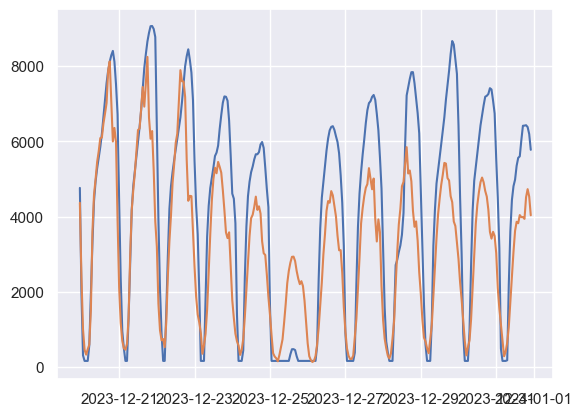

In [48]:
plt.plot(ensemble['test_predictions']['lstm']['Manhattan'])

Veo que LSTM está funcionando mal. Probemos predecir el set original de entrenamiento completo:

In [62]:
def predecir_2(ensemble, cant_dias=7, verbose=0, nro_pasos=5):
    
    df = pd.read_parquet('../data_export/prueba_ml.parquet')
    df.reset_index(inplace=True, drop=True)
    df['dia_semana'] = df['fecha'].dt.weekday + 1
    year = 2023
    us_holidays = holidays.US(years=year)
    us_holidays
    df['holiday'] = np.where(df['fecha'].isin(us_holidays), 1, 0)
    df['rain'] = df['rain'].shift(1)
    df['snowfall'] = df['snowfall'].shift(1)
    df.fillna(0.0, inplace=True)
    df['datetime'] = pd.to_datetime(df['fecha'].astype(str) + ' ' + df['hora'].astype(int).astype(str) + ':00:00')
    df.drop(columns='fecha', inplace=True)
    df.set_index('datetime', inplace=True)
    columnas_X = ['año', 'mes', 'dia', 'hora', 'dia_semana', 'holiday', 'temperature_2m', 'rain', 'relative_humidity_2m', 'snowfall']
    X = df[columnas_X]

    columnas_Y = ['Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island']

    lstm_model = ensemble['models']['lstm']
    scaler_X = ensemble['lstm_data']['scaler_x']
    scaler_Y = ensemble['lstm_data']['scaler_y']
    X_scaled = scaler_X.transform(X)
    X_reshaped = generador_X_lstm(X_scaled)
    lstm_pred = lstm_model.predict(X_reshaped, verbose=verbose)
    Y_predict_df = pd.DataFrame(lstm_pred, columns=columnas_Y)
    Y_predict_original = scaler_Y.inverse_transform(Y_predict_df)
    indice_pred = X.iloc[nro_pasos-1:-1,:].index
    lstm_predictions_df = pd.DataFrame(Y_predict_original, columns= Y.columns, index=indice_pred)

    lstm_predictions = {}
    rf_predictions = {}
    xgb_predictions = {}
    lgbm_predictions = {}

    nyc_predictions = {}
    for district in columnas_Y:

        lstm_predictions[district] = pd.DataFrame(lstm_predictions_df[district].rename('lstm'))

        rf_model = ensemble['models']['rf'][district]
        rf_pred = rf_model.predict(X.iloc[nro_pasos-1:-1,:])
        rf_pred_df = pd.DataFrame({'rf': rf_pred}, index=indice_pred)
        rf_predictions[district] = rf_pred_df

        xgb_model = ensemble['models']['xgb'][district]
        xgb_pred = xgb_model.predict(X.iloc[nro_pasos-1:-1,:])
        xgb_pred_df = pd.DataFrame({'xgb': xgb_pred}, index=indice_pred)
        xgb_predictions[district] = xgb_pred_df

        lgbm_model = ensemble['models']['lgbm'][district]
        lgbm_pred = lgbm_model.predict(X.iloc[nro_pasos-1:-1,:])
        lgbm_pred_df = pd.DataFrame({'lgbm': lgbm_pred}, index=indice_pred)
        lgbm_predictions[district] = lgbm_pred_df

        nyc_predictions[district] = pd.concat([lstm_predictions[district], rf_pred_df, xgb_pred_df, lgbm_pred_df ], axis=1)
    

    return nyc_predictions

In [63]:
df_pred_2 = predecir_2(ensemble)

In [65]:
df_pred_2['Manhattan']

lstm           rf          xgb         lgbm
datetime                                                               
2023-11-01 04:00:00   200.838181   682.179711   701.205322   737.501575
2023-11-01 05:00:00  1119.951782   658.065041   660.293823   863.223722
2023-11-01 06:00:00  2132.785645  1584.474928  1710.356445  1890.078848
2023-11-01 07:00:00  3339.145508  4019.771567  4087.957520  4118.260615
2023-11-01 08:00:00  4418.942383  5470.580420  5174.260254  5196.353766
...                          ...          ...          ...          ...
2023-12-31 18:00:00  6416.866211  5911.556346  6869.698730  7129.432355
2023-12-31 19:00:00  6427.206543  5047.735393  5911.618164  6097.524798
2023-12-31 20:00:00  6378.117676  4740.825251  4940.993652  5558.798252
2023-12-31 21:00:00  6192.221680  4546.057245  5065.776367  5611.573737
2023-12-31 22:00:00  5773.041992  3915.825286  4398.808594  4875.176244

[1459 rows x 4 columns]

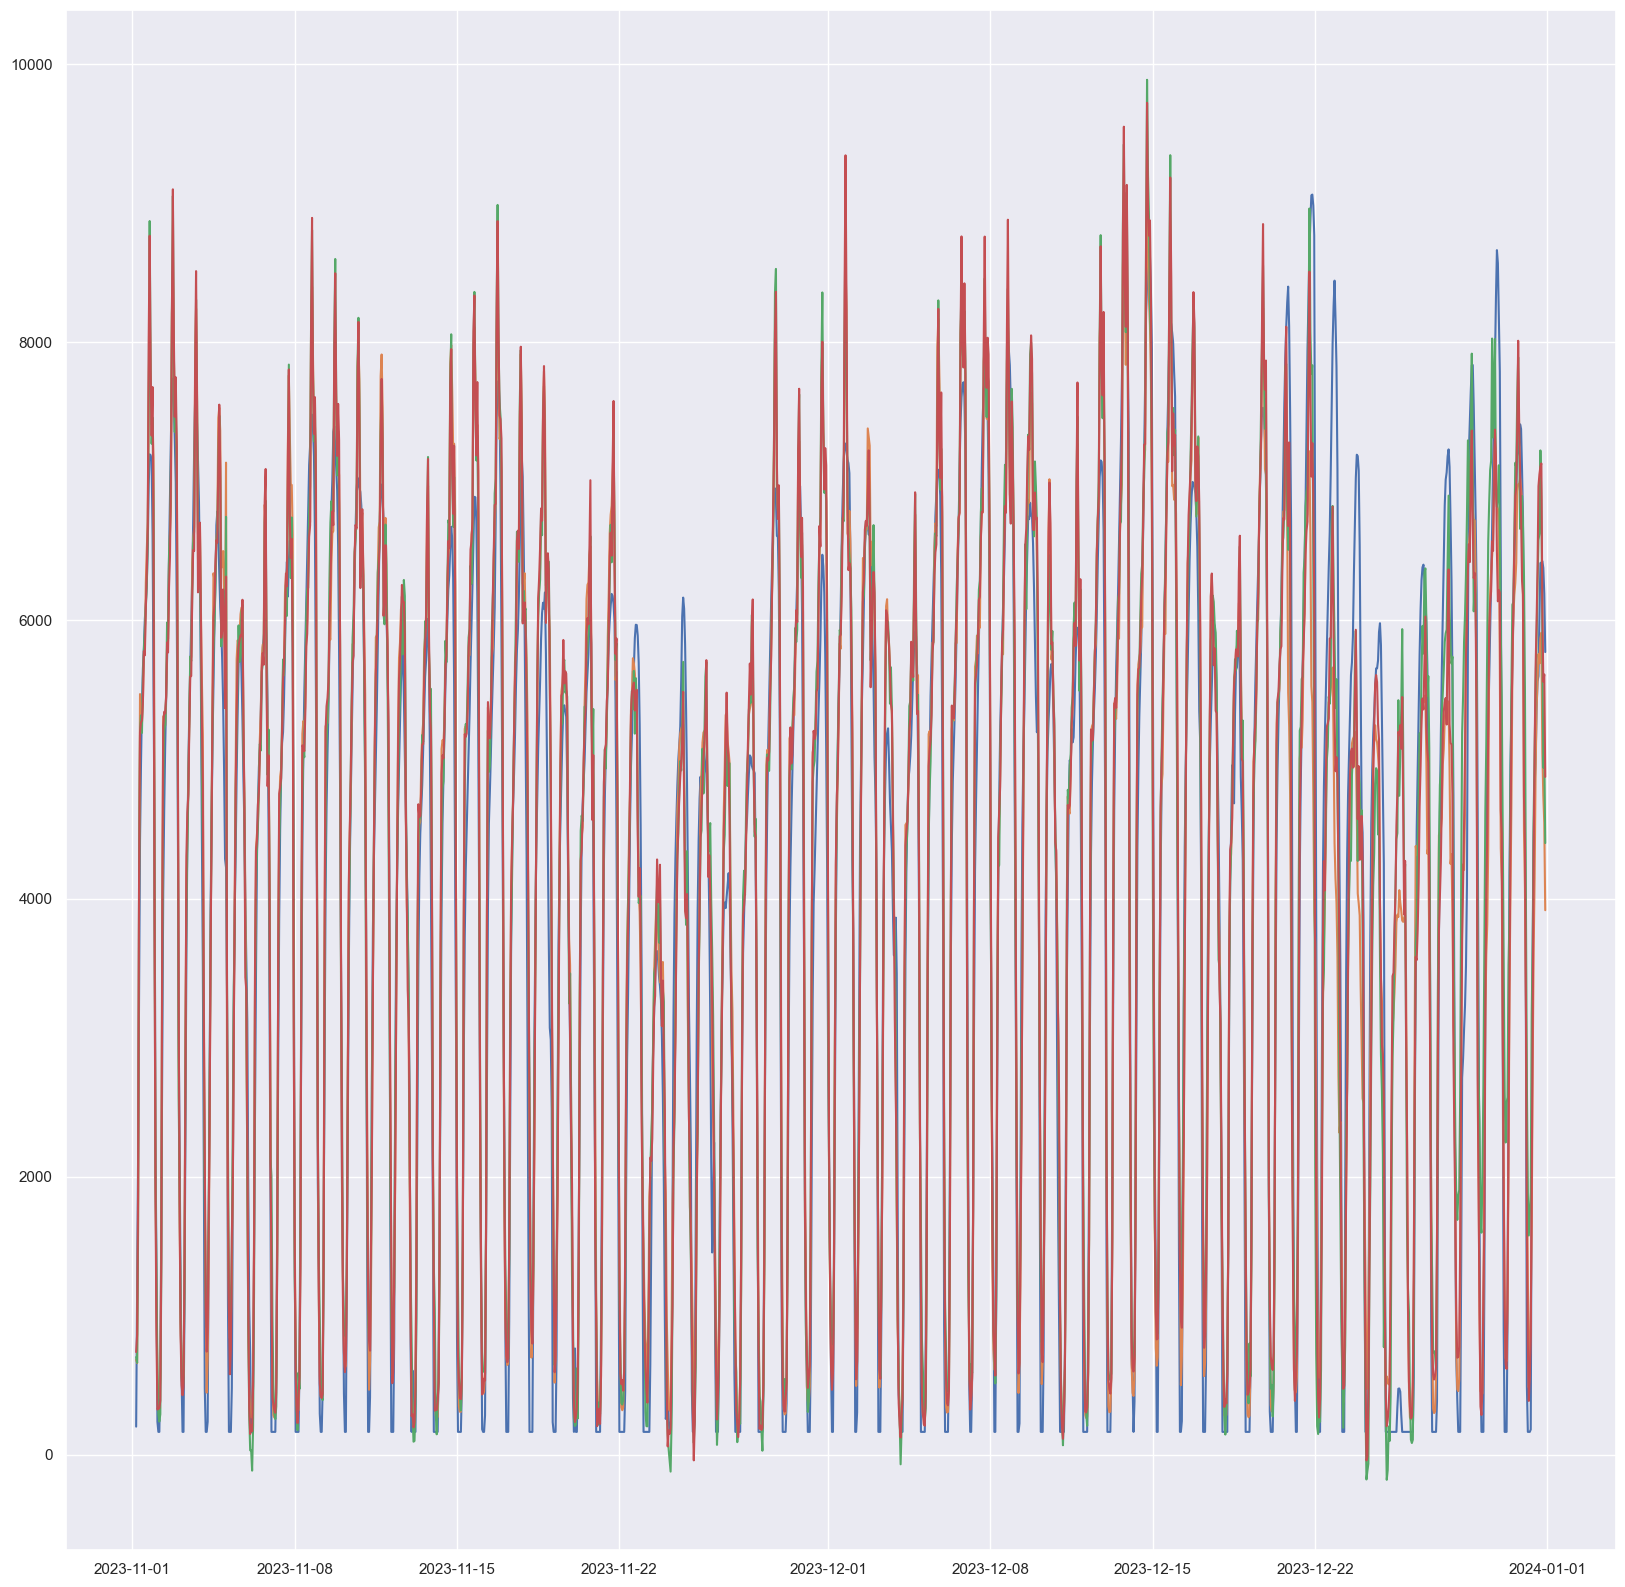

In [68]:
plt.figure(figsize=(20,20))
plt.plot(df_pred_2['Manhattan'])


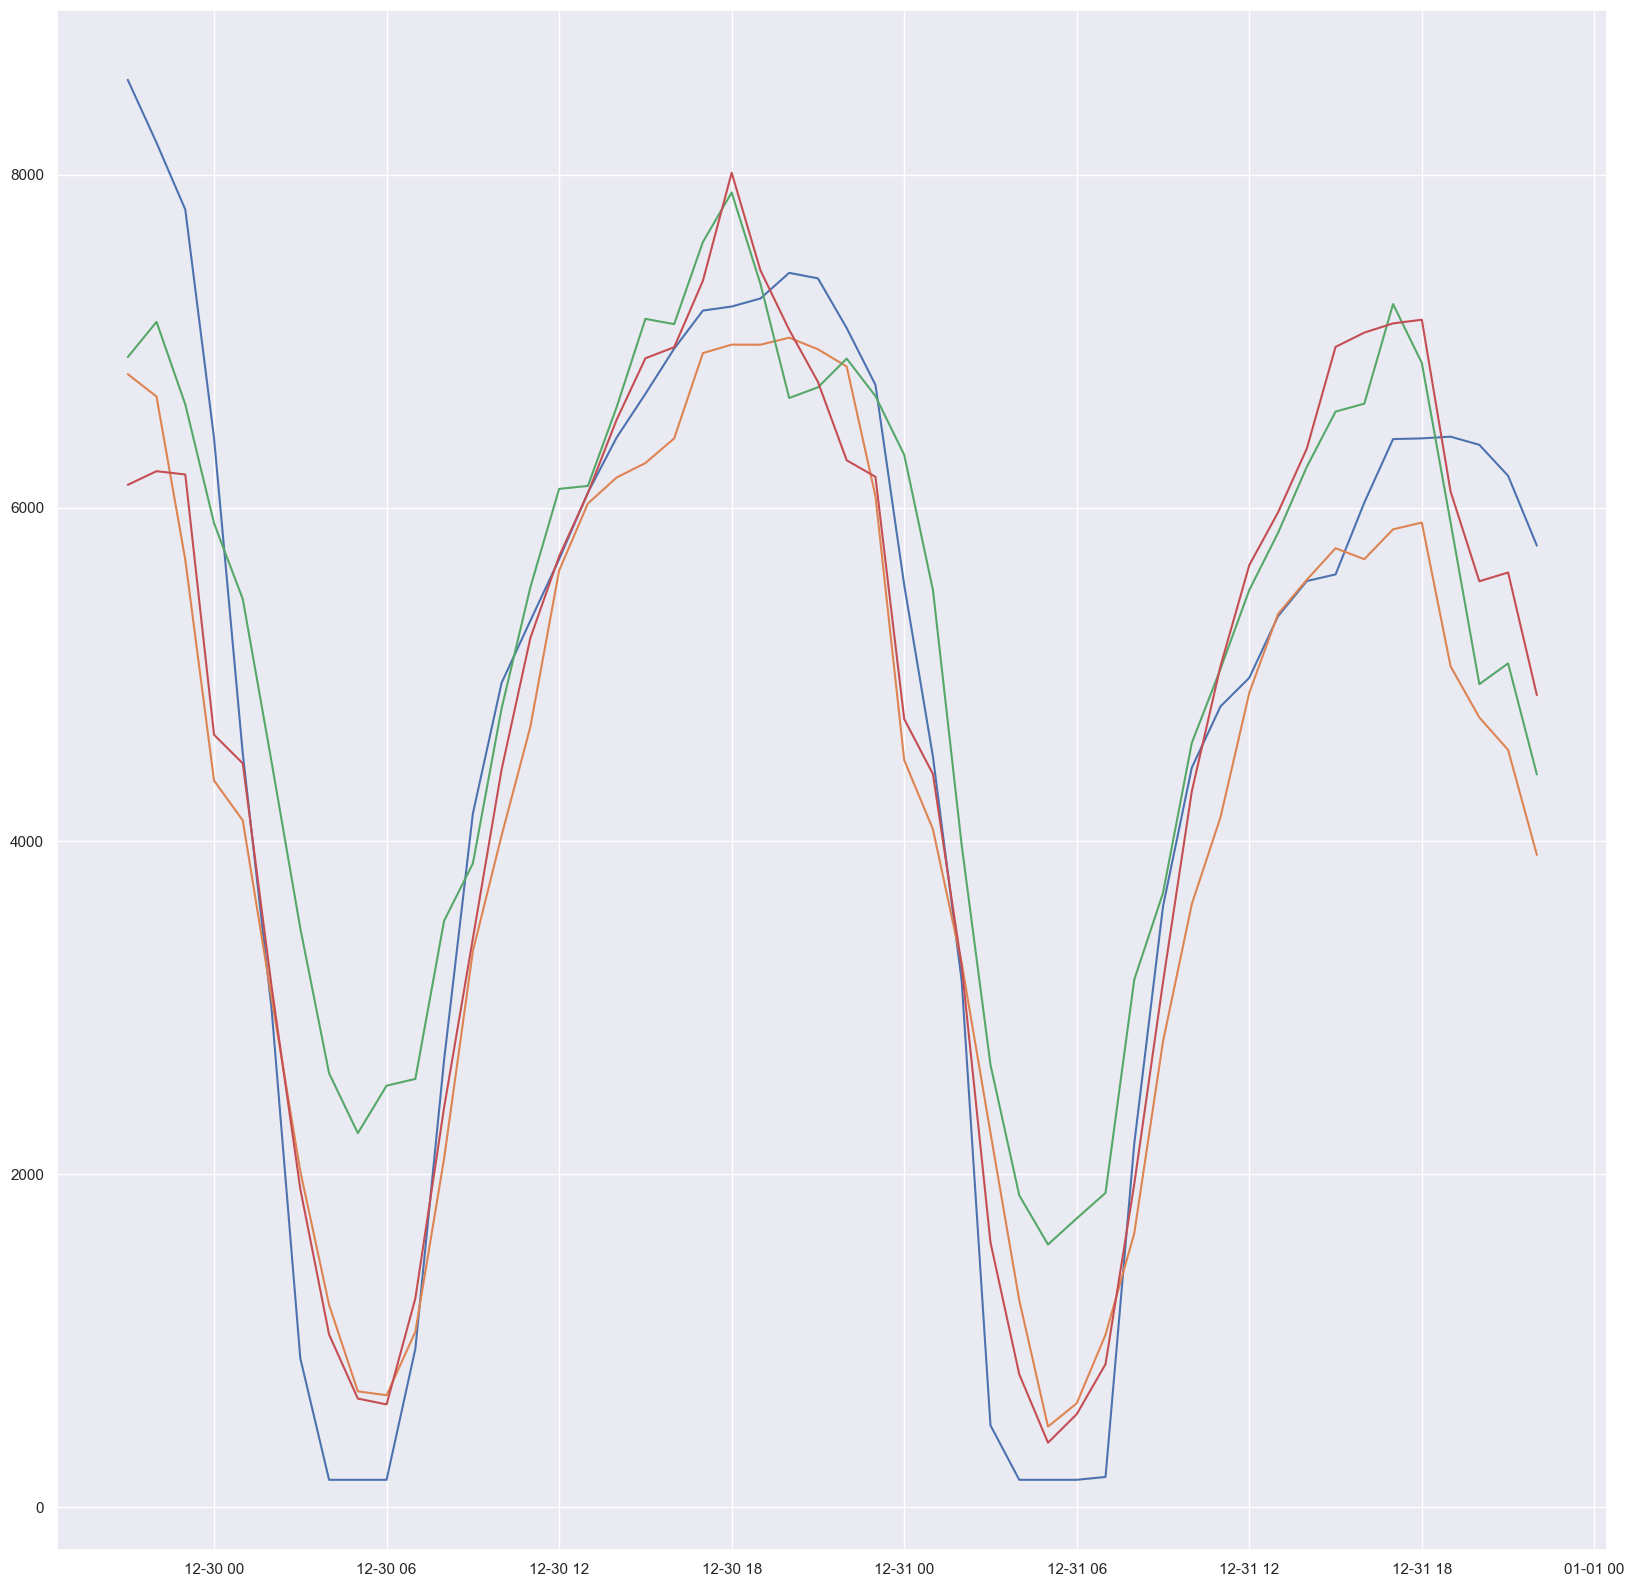

In [105]:
plt.figure(figsize=(20,20))
plt.plot(df_pred_2['Manhattan'].iloc[-50:,:])
plt.show()

Vemos que las predicciones de LSTM en el entrenamiento son buenas. Por lo tanto o está con mucho overfiting, o es necesario utilizar más datos de entrenamiento.

Hagamos otra prueba:

In [106]:
def predecir_3(ensemble, cant_dias=7, verbose=0, nro_pasos=5):
    
    df = pd.read_parquet('../data_export/prueba_ml.parquet')
    df.reset_index(inplace=True, drop=True)
    df['dia_semana'] = df['fecha'].dt.weekday + 1
    year = 2023
    us_holidays = holidays.US(years=year)
    us_holidays
    df['holiday'] = np.where(df['fecha'].isin(us_holidays), 1, 0)
    df['rain'] = df['rain'].shift(1)
    df['snowfall'] = df['snowfall'].shift(1)
    df.fillna(0.0, inplace=True)
    df['datetime'] = pd.to_datetime(df['fecha'].astype(str) + ' ' + df['hora'].astype(int).astype(str) + ':00:00')
    df.drop(columns='fecha', inplace=True)
    df.set_index('datetime', inplace=True)
    df['año'] = 2023
    df['mes'] = 10
    columnas_X = ['año', 'mes', 'dia', 'hora', 'dia_semana', 'holiday', 'temperature_2m', 'rain', 'relative_humidity_2m', 'snowfall']
    X = df[columnas_X]

    columnas_Y = ['Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island']

    lstm_model = ensemble['models']['lstm']
    scaler_X = ensemble['lstm_data']['scaler_x']
    scaler_Y = ensemble['lstm_data']['scaler_y']
    X_scaled = scaler_X.transform(X)
    X_reshaped = generador_X_lstm(X_scaled)
    lstm_pred = lstm_model.predict(X_reshaped, verbose=verbose)
    Y_predict_df = pd.DataFrame(lstm_pred, columns=columnas_Y)
    Y_predict_original = scaler_Y.inverse_transform(Y_predict_df)
    indice_pred = X.iloc[nro_pasos-1:-1,:].index
    lstm_predictions_df = pd.DataFrame(Y_predict_original, columns= Y.columns, index=indice_pred)

    lstm_predictions = {}
    rf_predictions = {}
    xgb_predictions = {}
    lgbm_predictions = {}

    nyc_predictions = {}
    for district in columnas_Y:

        lstm_predictions[district] = pd.DataFrame(lstm_predictions_df[district].rename('lstm'))

        rf_model = ensemble['models']['rf'][district]
        rf_pred = rf_model.predict(X.iloc[nro_pasos-1:-1,:])
        rf_pred_df = pd.DataFrame({'rf': rf_pred}, index=indice_pred)
        rf_predictions[district] = rf_pred_df

        xgb_model = ensemble['models']['xgb'][district]
        xgb_pred = xgb_model.predict(X.iloc[nro_pasos-1:-1,:])
        xgb_pred_df = pd.DataFrame({'xgb': xgb_pred}, index=indice_pred)
        xgb_predictions[district] = xgb_pred_df

        lgbm_model = ensemble['models']['lgbm'][district]
        lgbm_pred = lgbm_model.predict(X.iloc[nro_pasos-1:-1,:])
        lgbm_pred_df = pd.DataFrame({'lgbm': lgbm_pred}, index=indice_pred)
        lgbm_predictions[district] = lgbm_pred_df

        nyc_predictions[district] = pd.concat([lstm_predictions[district], rf_pred_df, xgb_pred_df, lgbm_pred_df ], axis=1)
    

    return nyc_predictions

In [107]:
df_pred_3 = predecir(ensemble)

In [108]:
df_pred_3['Manhattan']

lstm           rf          xgb         lgbm     ensemble
datetime                                                                      
2024-04-19 22:00:00  163.0  5701.071490  5976.322266  5926.254752  4552.202645
2024-04-19 23:00:00  163.0  5079.252579  5003.400879  5276.014720  3980.799377
2024-04-20 00:00:00  163.0  5954.817417  4803.527832  4460.933355  3940.382960
2024-04-20 01:00:00  163.0  5804.639250  4258.867676  4234.186338  3708.510905
2024-04-20 02:00:00  163.0  3296.243582  3090.355957  3144.793204  2483.720176
...                    ...          ...          ...          ...          ...
2024-04-25 22:00:00  163.0  3993.824423  5497.417969  4564.885190  3629.257984
2024-04-25 23:00:00  163.0  3139.334381  3645.651611  3683.825390  2722.408858
2024-04-26 00:00:00  163.0  2150.787333  1857.944580  1543.441461  1458.889962
2024-04-26 01:00:00  163.0  1273.097667   819.002441   506.703411   701.653608
2024-04-26 02:00:00  163.0   889.526407   631.505432   116.223851   452.215053

[149 rows x 5 columns]

Vamos a realizar el escalado de los datos con un escalador nuevo, y no utilizando el escalador obtenido en el entrenamiento:

In [61]:
def predecir(ensemble, cant_dias=7, verbose=0, nro_pasos=5, test=False, test_data=None):
    
    if test == True:
        X = test_data
    if test == False:
        X = generar_X(nro_pasos=nro_pasos, cantidad_dias=cant_dias)

    columnas_Y = ['Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island']

    lstm_model = ensemble['models']['lstm']
    scaler_X = MinMaxScaler()
    scaler_Y = ensemble['lstm_data']['scaler_y']
    X_scaled = scaler_X.fit_transform(X)
    X_reshaped = generador_X_lstm(X_scaled)
    lstm_pred = lstm_model.predict(X_reshaped, verbose=verbose)
    Y_predict_df = pd.DataFrame(lstm_pred, columns=columnas_Y)
    Y_predict_original = scaler_Y.inverse_transform(Y_predict_df)
    indice_pred = X.iloc[nro_pasos-1:-1,:].index
    lstm_predictions_df = pd.DataFrame(Y_predict_original, columns= columnas_Y, index=indice_pred)

    ponderaciones = ensemble['ponderaciones']

    lstm_predictions = {}
    rf_predictions = {}
    xgb_predictions = {}
    lgbm_predictions = {}

    nyc_predictions = {}
    for district in columnas_Y:

        lstm_predictions[district] = pd.DataFrame(lstm_predictions_df[district].rename('lstm'))

        rf_model = ensemble['models']['rf'][district]
        rf_pred = rf_model.predict(X.iloc[nro_pasos-1:-1,:])
        rf_pred_df = pd.DataFrame({'rf': rf_pred}, index=indice_pred)
        rf_predictions[district] = rf_pred_df

        xgb_model = ensemble['models']['xgb'][district]
        xgb_pred = xgb_model.predict(X.iloc[nro_pasos-1:-1,:])
        xgb_pred_df = pd.DataFrame({'xgb': xgb_pred}, index=indice_pred)
        xgb_predictions[district] = xgb_pred_df

        lgbm_model = ensemble['models']['lgbm'][district]
        lgbm_pred = lgbm_model.predict(X.iloc[nro_pasos-1:-1,:])
        lgbm_pred_df = pd.DataFrame({'lgbm': lgbm_pred}, index=indice_pred)
        lgbm_predictions[district] = lgbm_pred_df

        lstm_pond = ponderaciones[district]['lstm']
        rf_pond = ponderaciones[district]['rf']
        xgb_pond = ponderaciones[district]['xgb']
        lgbm_pond = ponderaciones[district]['lgbm']

        ensemble_predictions = lstm_pond*lstm_predictions[district]['lstm'] + rf_pond*rf_pred_df['rf'] + xgb_pond*xgb_pred_df['xgb'] + lgbm_pond*lgbm_pred_df['lgbm']
        ensemble_predictions.rename('ensemble', inplace=True)
        ensemble_predictions_df = pd.DataFrame(ensemble_predictions, index=indice_pred)

        nyc_predictions[district] = pd.concat([lstm_predictions[district], rf_pred_df, xgb_pred_df, lgbm_pred_df, ensemble_predictions_df ], axis=1)
        
        condicion = lambda x: 0 if x < 0 else x
        nyc_predictions[district] = nyc_predictions[district].applymap(condicion)

    return nyc_predictions
    

In [34]:
pred = predecir(ensemble)

In [35]:
pred['Manhattan']

lstm           rf          xgb         lgbm  \
datetime                                                                  
2024-04-20 08:00:00  3373.491211  2205.418333  2832.209961  2061.621848   
2024-04-20 09:00:00  4296.797363  3432.886996  3786.724854  3390.426071   
2024-04-20 10:00:00  4874.853516  4334.268793  4796.064453  4463.753224   
2024-04-20 11:00:00  5364.533691  5263.704711  5511.858398  5277.368016   
2024-04-20 12:00:00  5663.432129  5858.992532  6091.074707  5614.094639   
...                          ...          ...          ...          ...   
2024-04-26 22:00:00  5104.964844  4103.320864  4432.049316  3985.906670   
2024-04-26 23:00:00  4618.325684  3363.946333  3485.945312  3883.919333   
2024-04-27 00:00:00  3623.276123  3857.299167  3289.989990  3342.113949   
2024-04-27 01:00:00  2426.894775  3574.103333  2897.405518  3039.562921   
2024-04-27 02:00:00   668.363403  2578.600000  2677.272461  2082.037684   

                        ensemble  
datetime                          
2024-04-20 08:00:00  2588.193764  
2024-04-20 09:00:00  3706.470390  
2024-04-20 10:00:00  4605.649859  
2024-04-20 11:00:00  5350.847398  
2024-04-20 12:00:00  5804.639801  
...                          ...  
2024-04-26 22:00:00  4382.454446  
2024-04-26 23:00:00  3821.959324  
2024-04-27 00:00:00  3527.559101  
2024-04-27 01:00:00  3002.206647  
2024-04-27 02:00:00  2029.318650  

[163 rows x 5 columns]

El problema fue solucionado con el escalador.

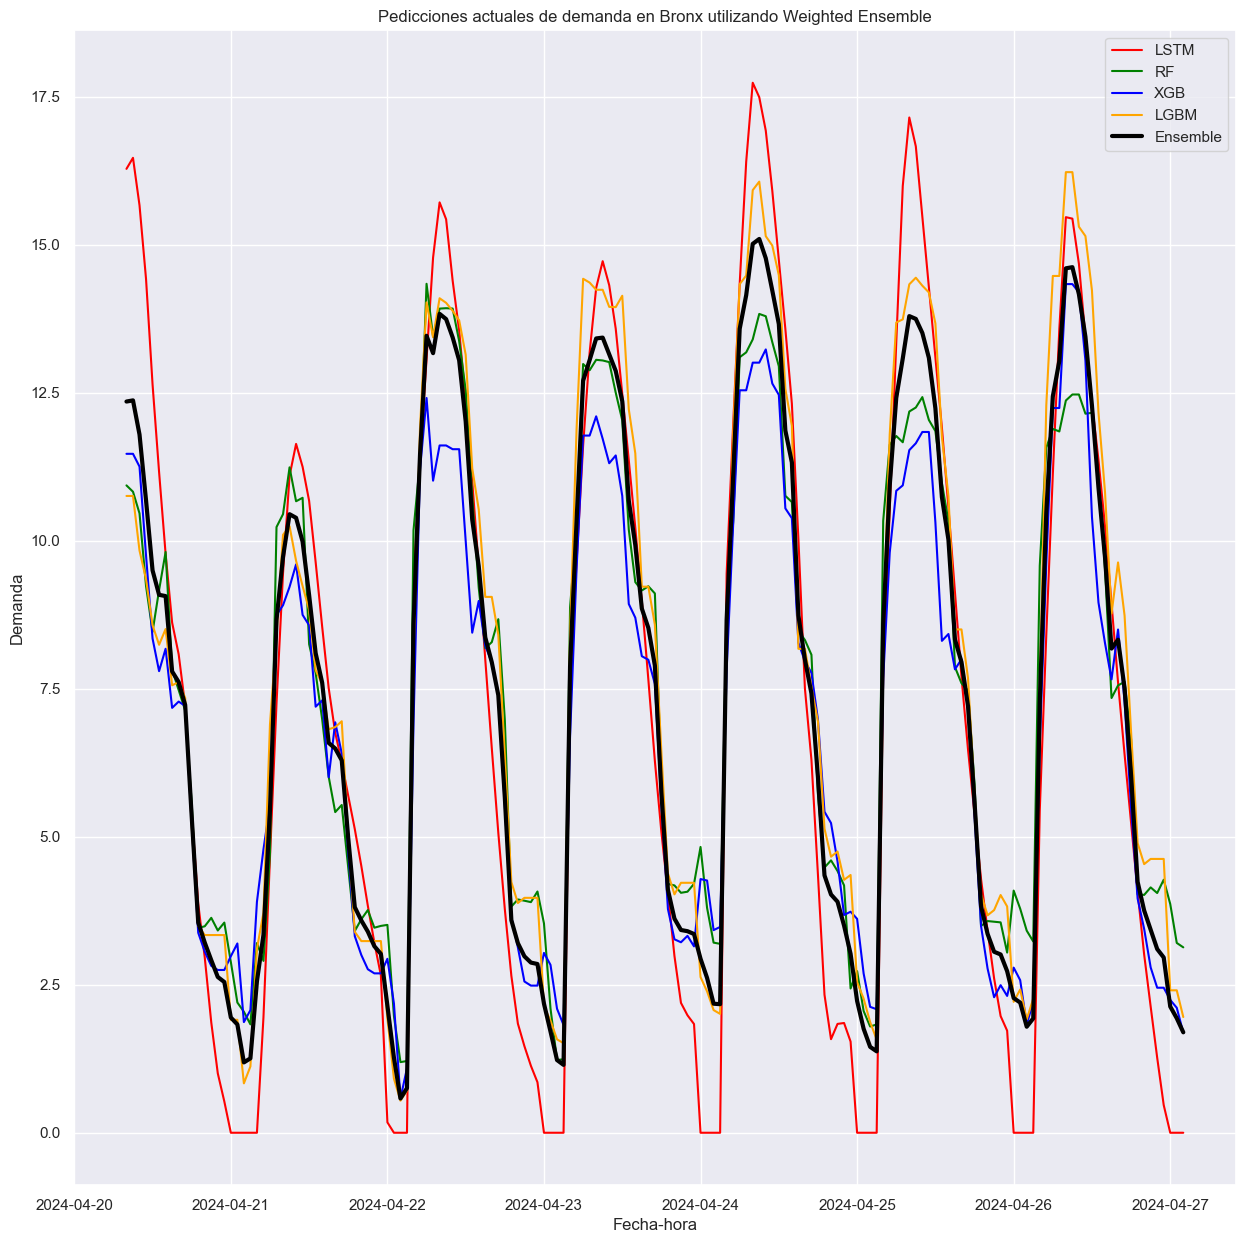

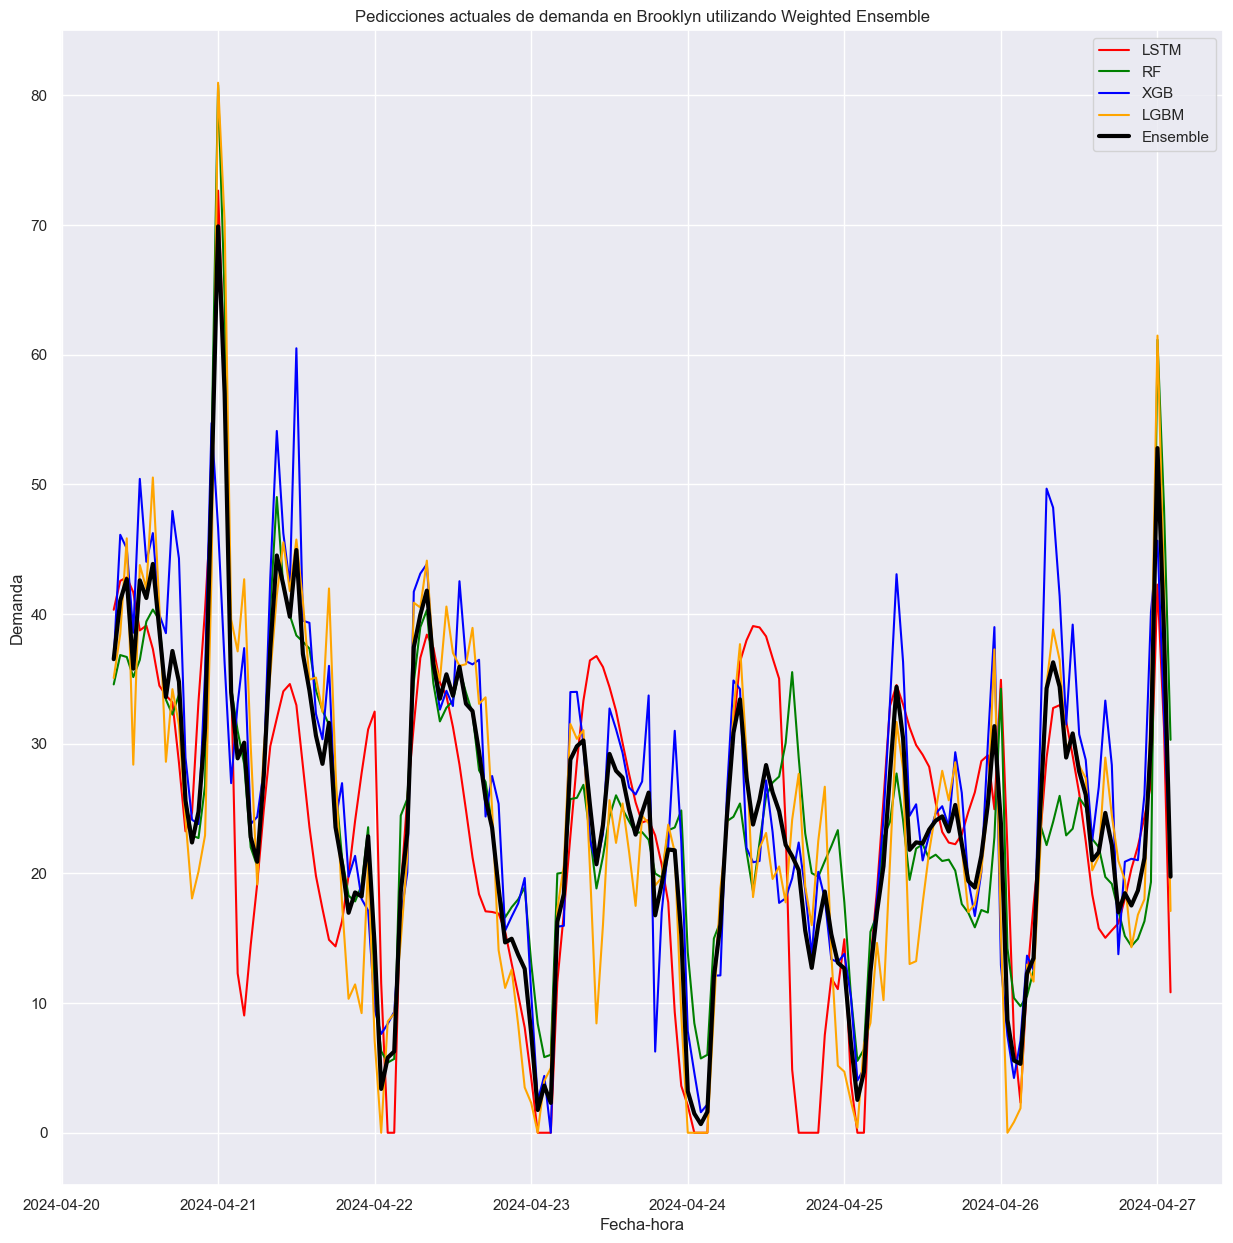

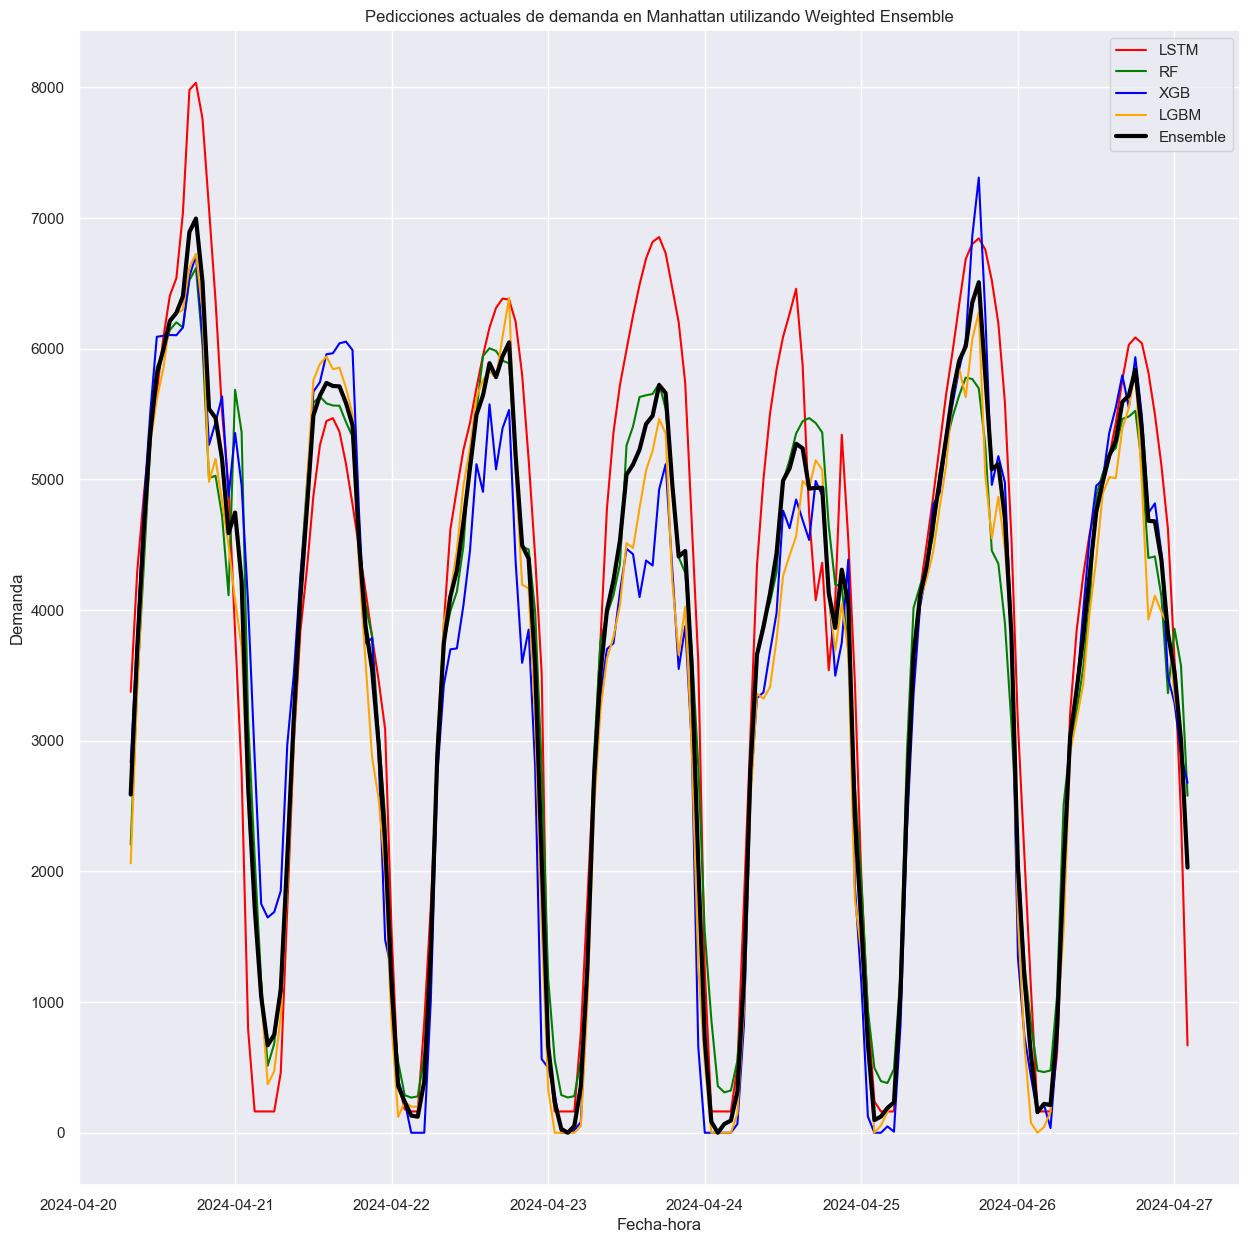

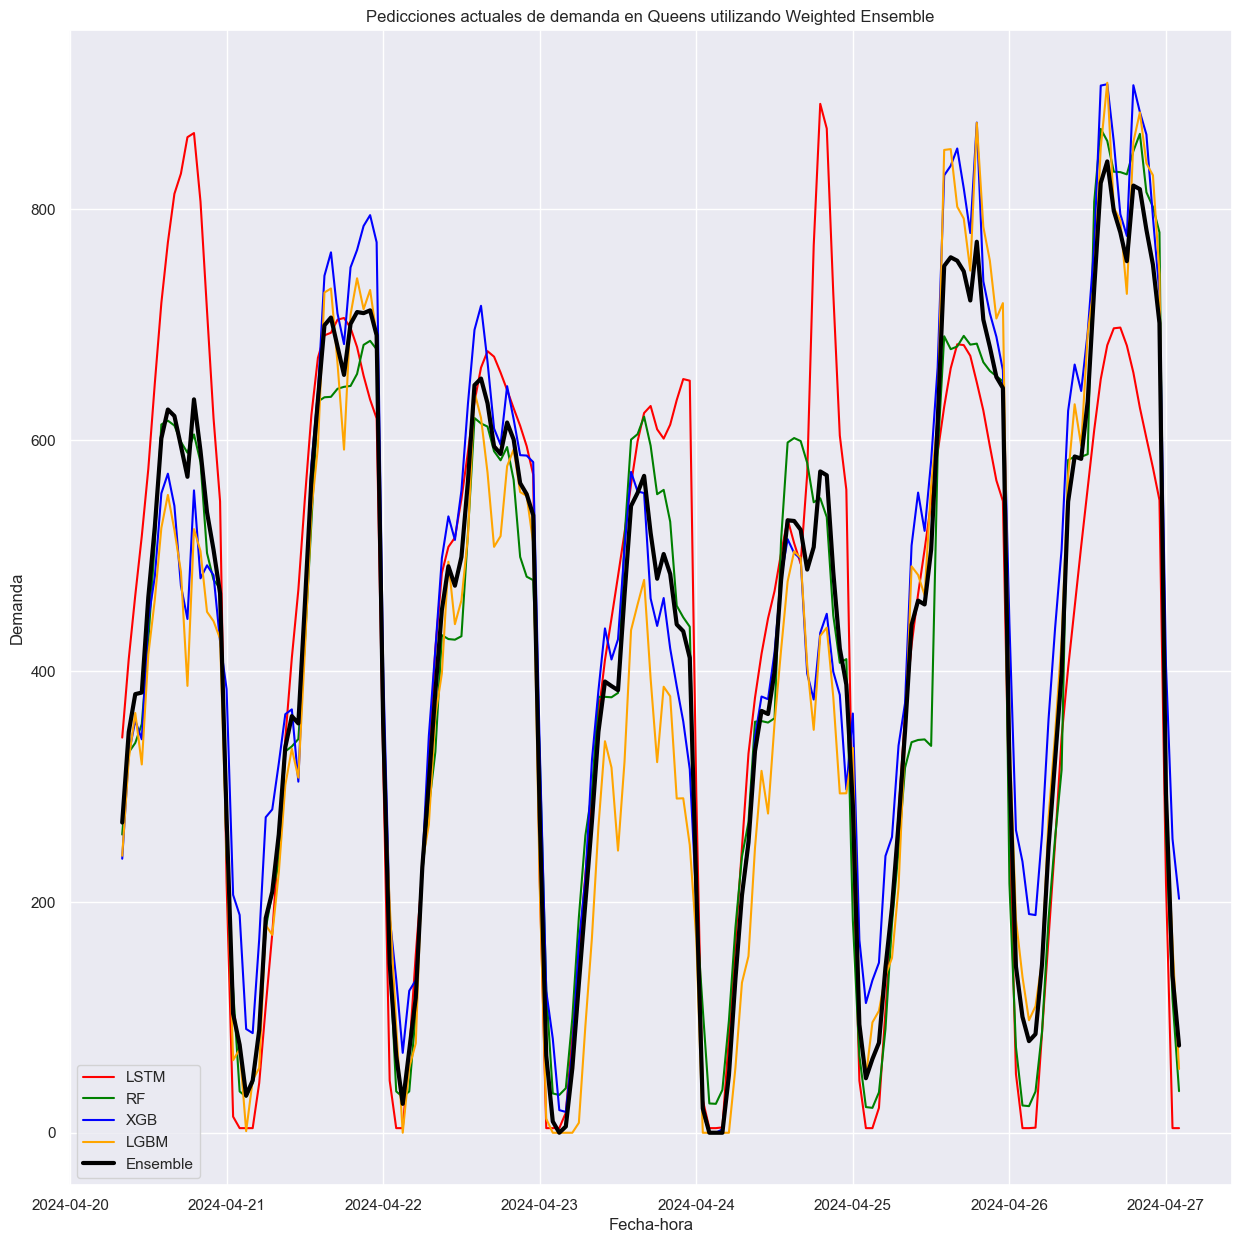

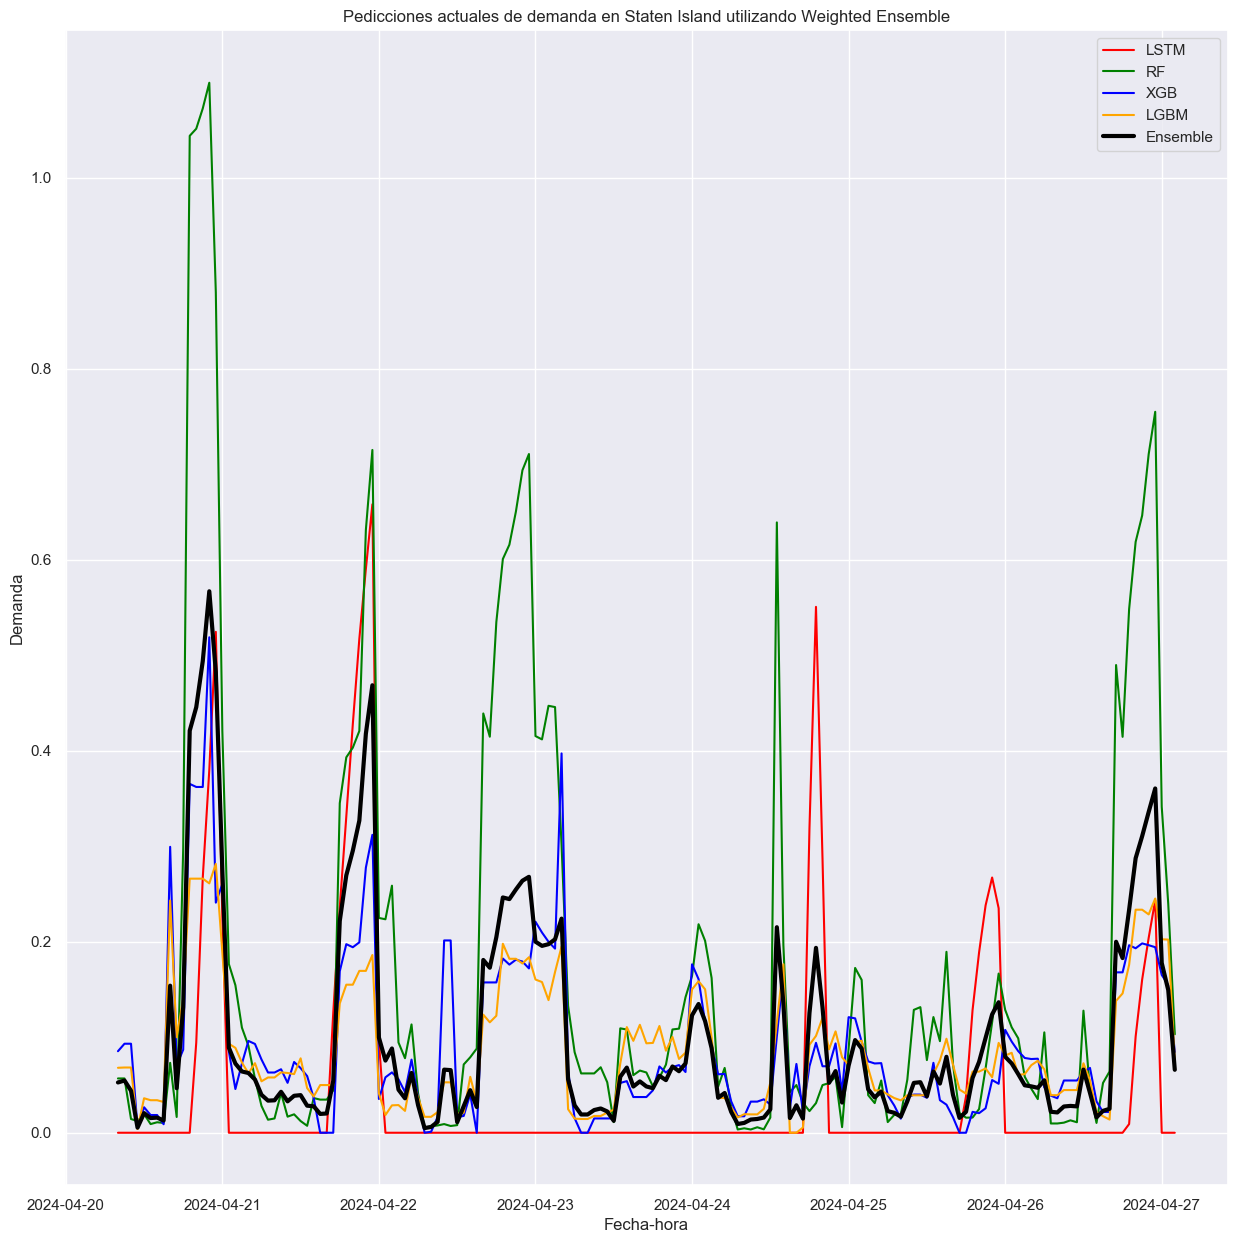

In [38]:
for district in pred.keys():
    plt.figure(figsize=(15,15))
    plt.plot(pred[district]['lstm'], label='LSTM', color='red')
    plt.plot(pred[district]['rf'], label='RF', color='green')
    plt.plot(pred[district]['xgb'], label='XGB', color='blue')
    plt.plot(pred[district]['lgbm'], label='LGBM', color='orange')
    plt.plot(pred[district]['ensemble'], label='Ensemble', lw=3, color='black')
    plt.title(f'Pedicciones actuales de demanda en {district} utilizando Weighted Ensemble')
    plt.xlabel('Fecha-hora')
    plt.ylabel('Demanda')
    plt.legend()
    plt.show()

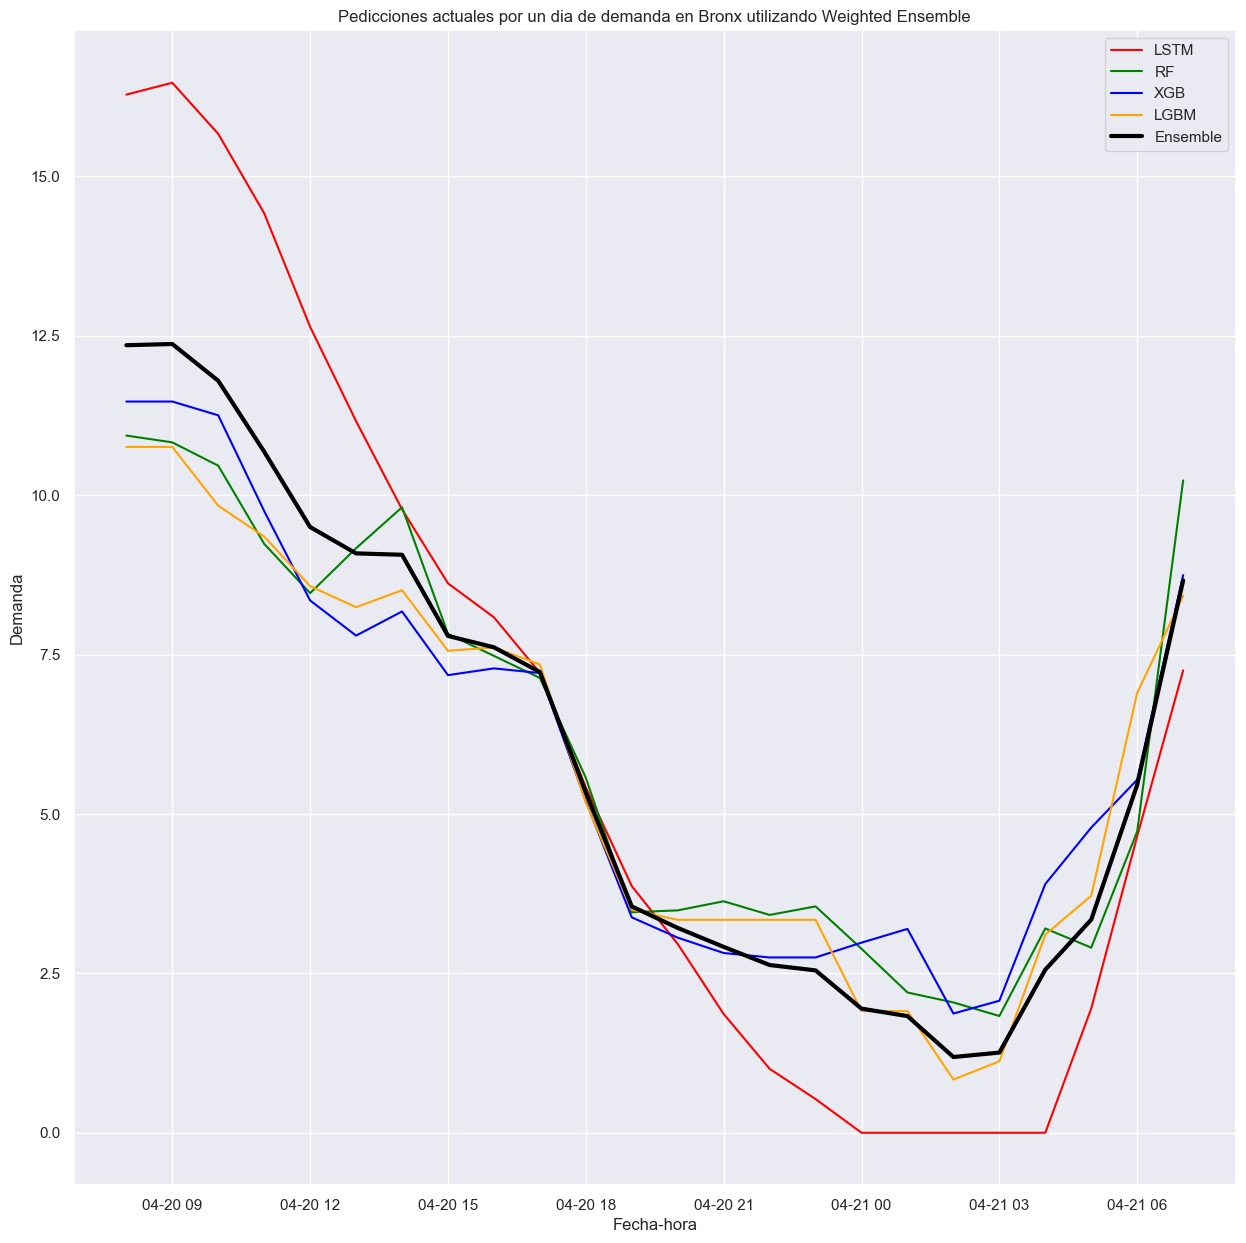

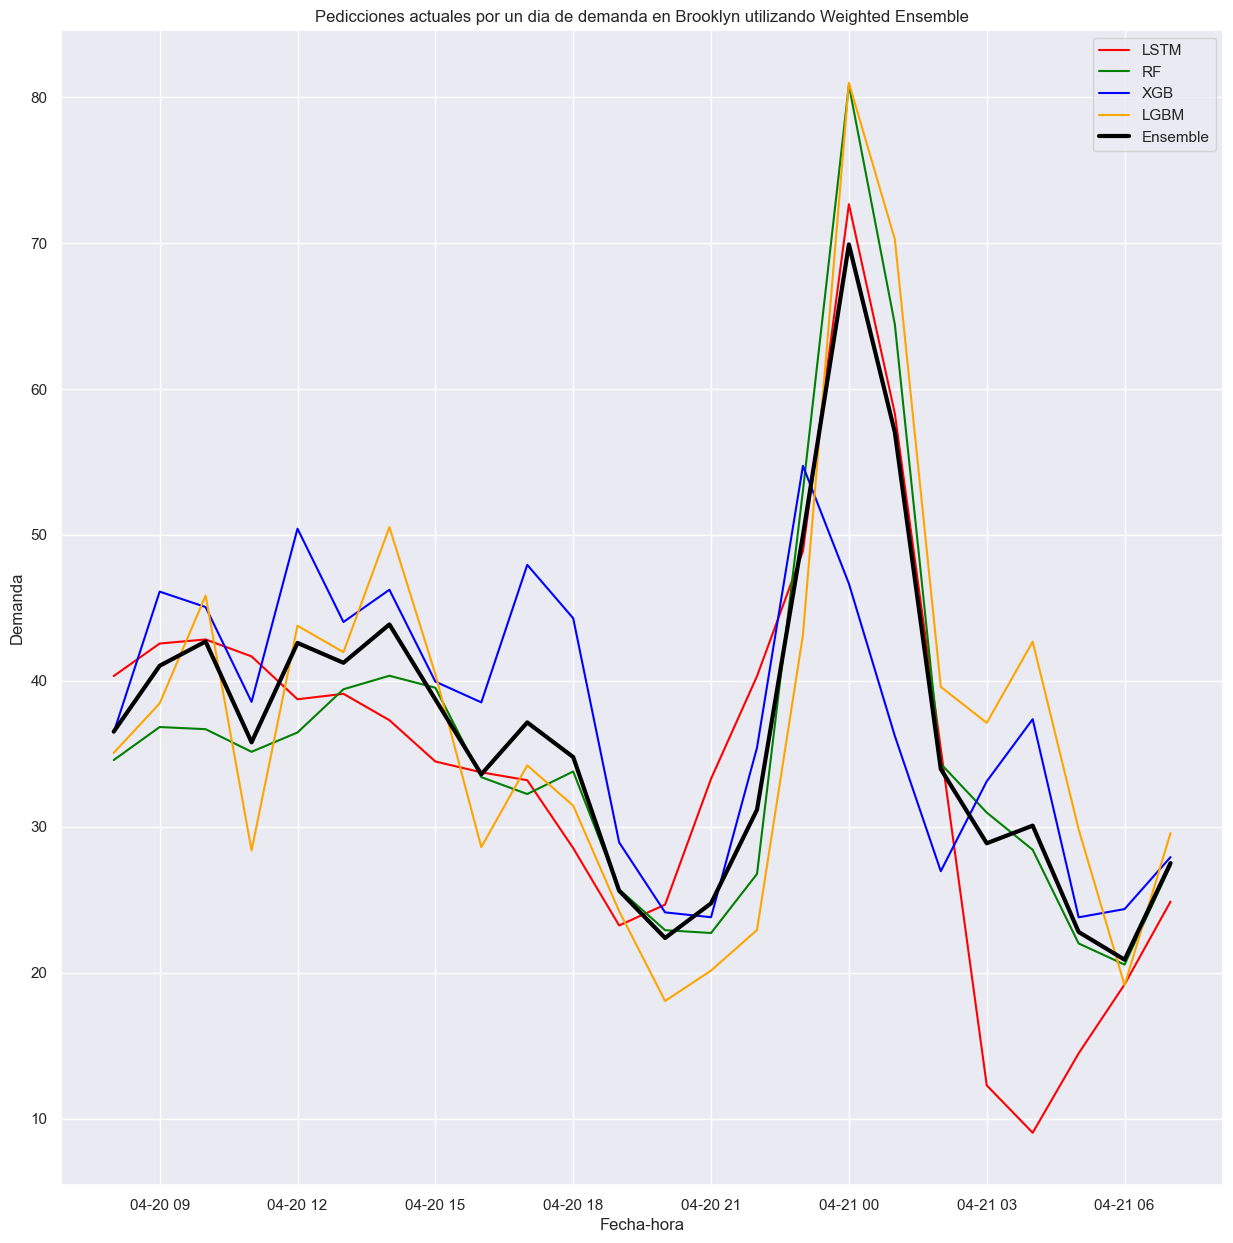

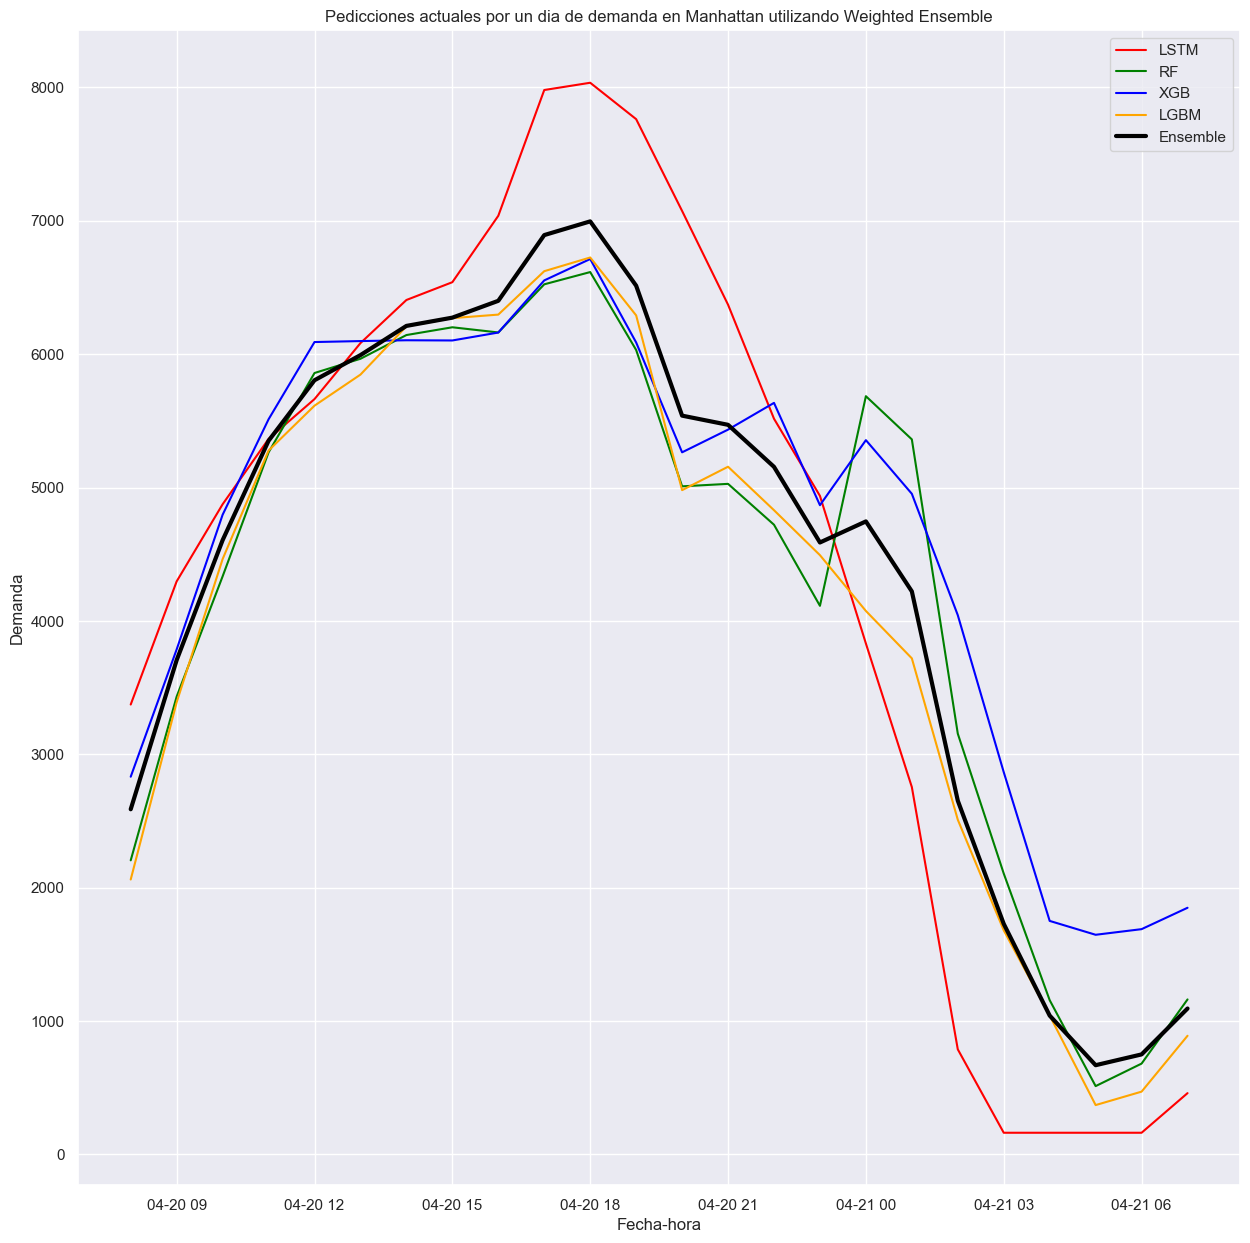

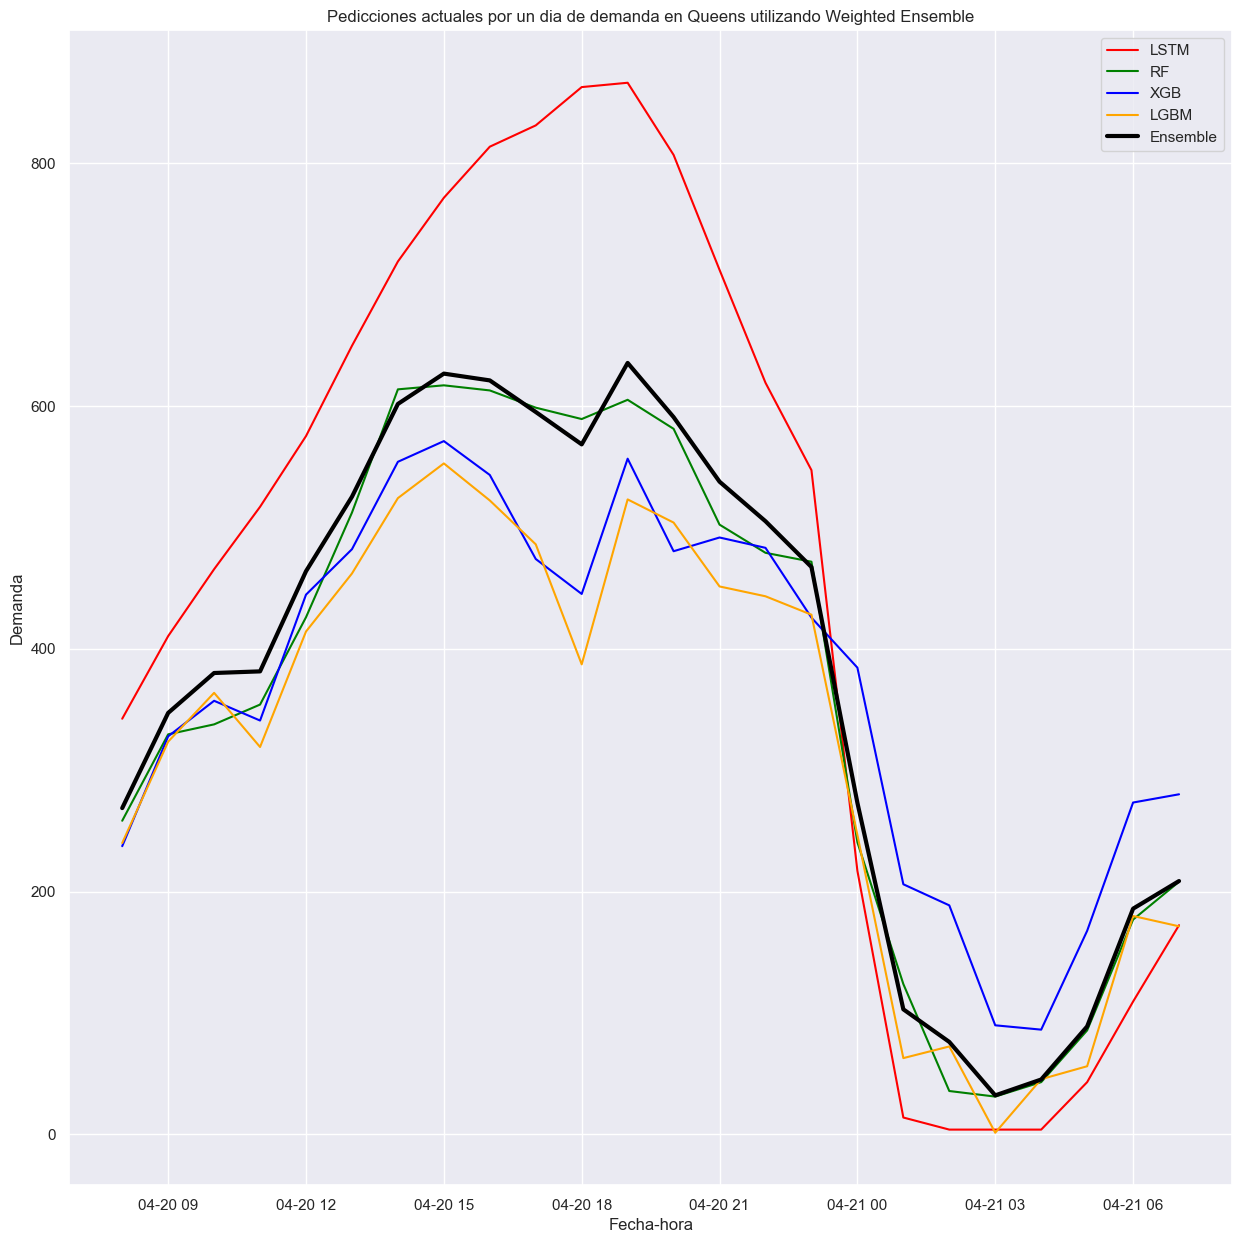

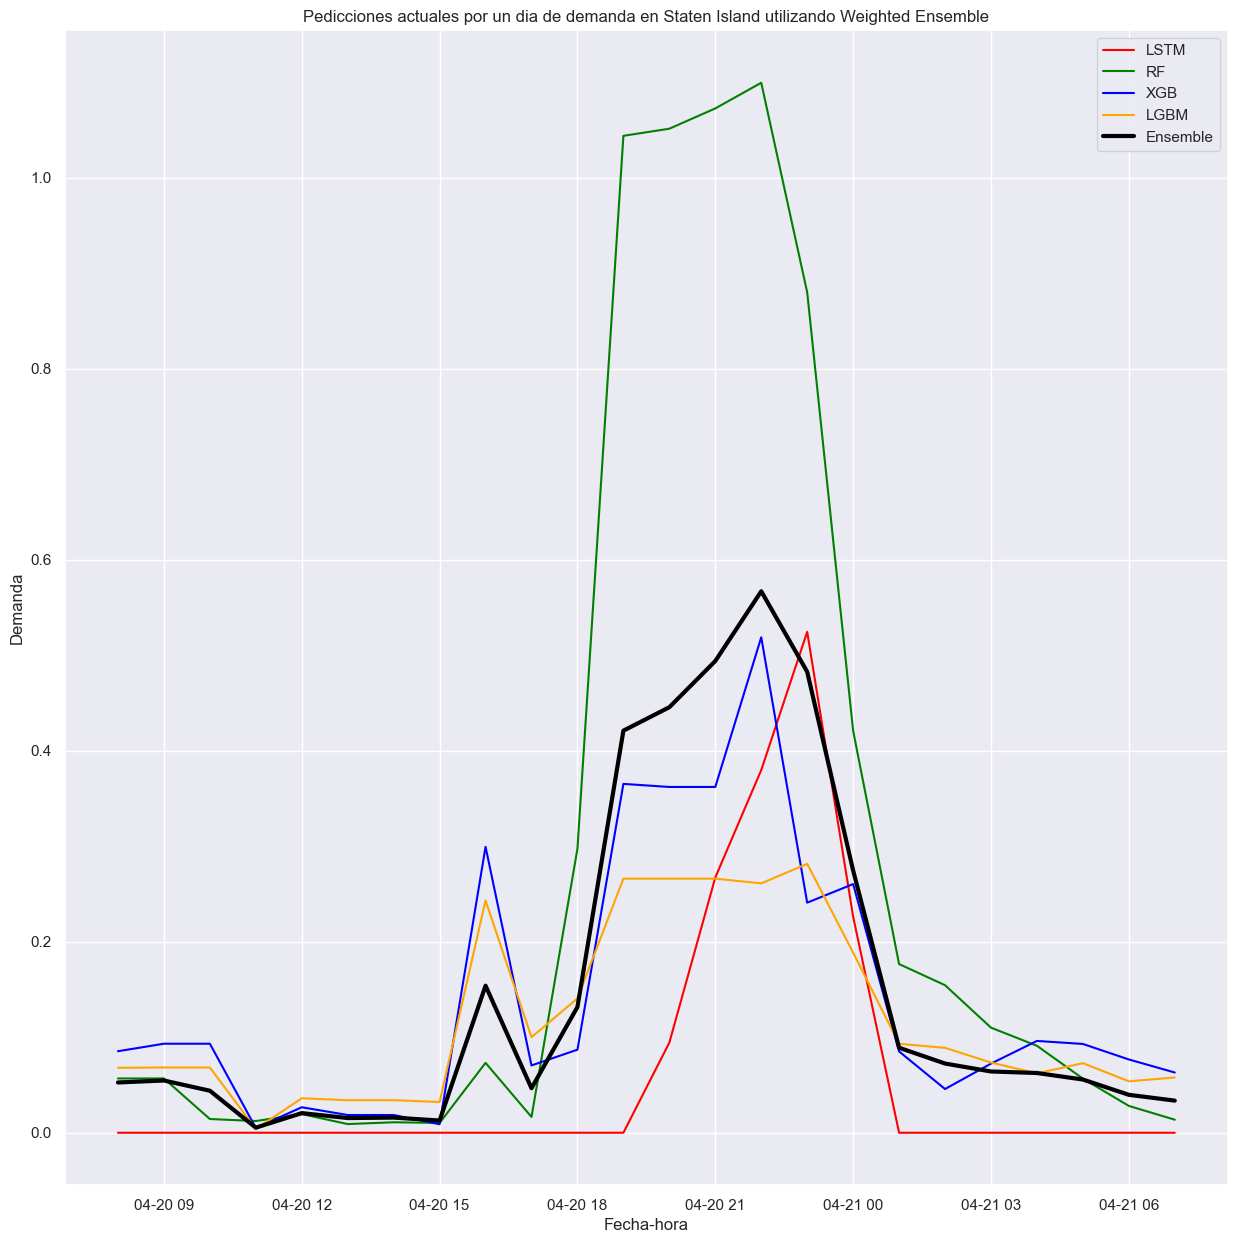

In [42]:
for district in pred.keys():
    plt.figure(figsize=(15,15))
    plt.plot(pred[district].iloc[:24,:]['lstm'], label='LSTM', color='red')
    plt.plot(pred[district].iloc[:24,:]['rf'], label='RF', color='green')
    plt.plot(pred[district].iloc[:24,:]['xgb'], label='XGB', color='blue')
    plt.plot(pred[district].iloc[:24,:]['lgbm'], label='LGBM', color='orange')
    plt.plot(pred[district].iloc[:24,:]['ensemble'], label='Ensemble', lw=3, color='black')
    plt.title(f'Pedicciones actuales por un dia de demanda en {district} utilizando Weighted Ensemble')
    plt.xlabel('Fecha-hora')
    plt.ylabel('Demanda')
    plt.legend()
    plt.show()

In [57]:
def graficar_predicciones(pred):
    
    for district in pred.keys():
        plt.figure(figsize=(12,12))
        sns.set_style('darkgrid')
        sns.lineplot(pred[district]['lstm'], label='LSTM', color='red')
        sns.lineplot(pred[district]['rf'], label='RF', color='green')
        sns.lineplot(pred[district]['xgb'], label='XGB', color='blue')
        sns.lineplot(pred[district]['lgbm'], label='LGBM', color='orange')
        sns.lineplot(pred[district]['ensemble'], label='Ensemble', lw=2.5, color='black')
        plt.title(f'Pedicciones actuales de demanda en {district} utilizando Weighted Ensemble', fontsize=14)
        plt.xlabel('Fecha-hora', fontsize=12)
        plt.ylabel('Demanda', fontsize=12)
        plt.legend(title='Modelo', fontsize=10, title_fontsize='12')
        plt.tight_layout()
        plt.show()

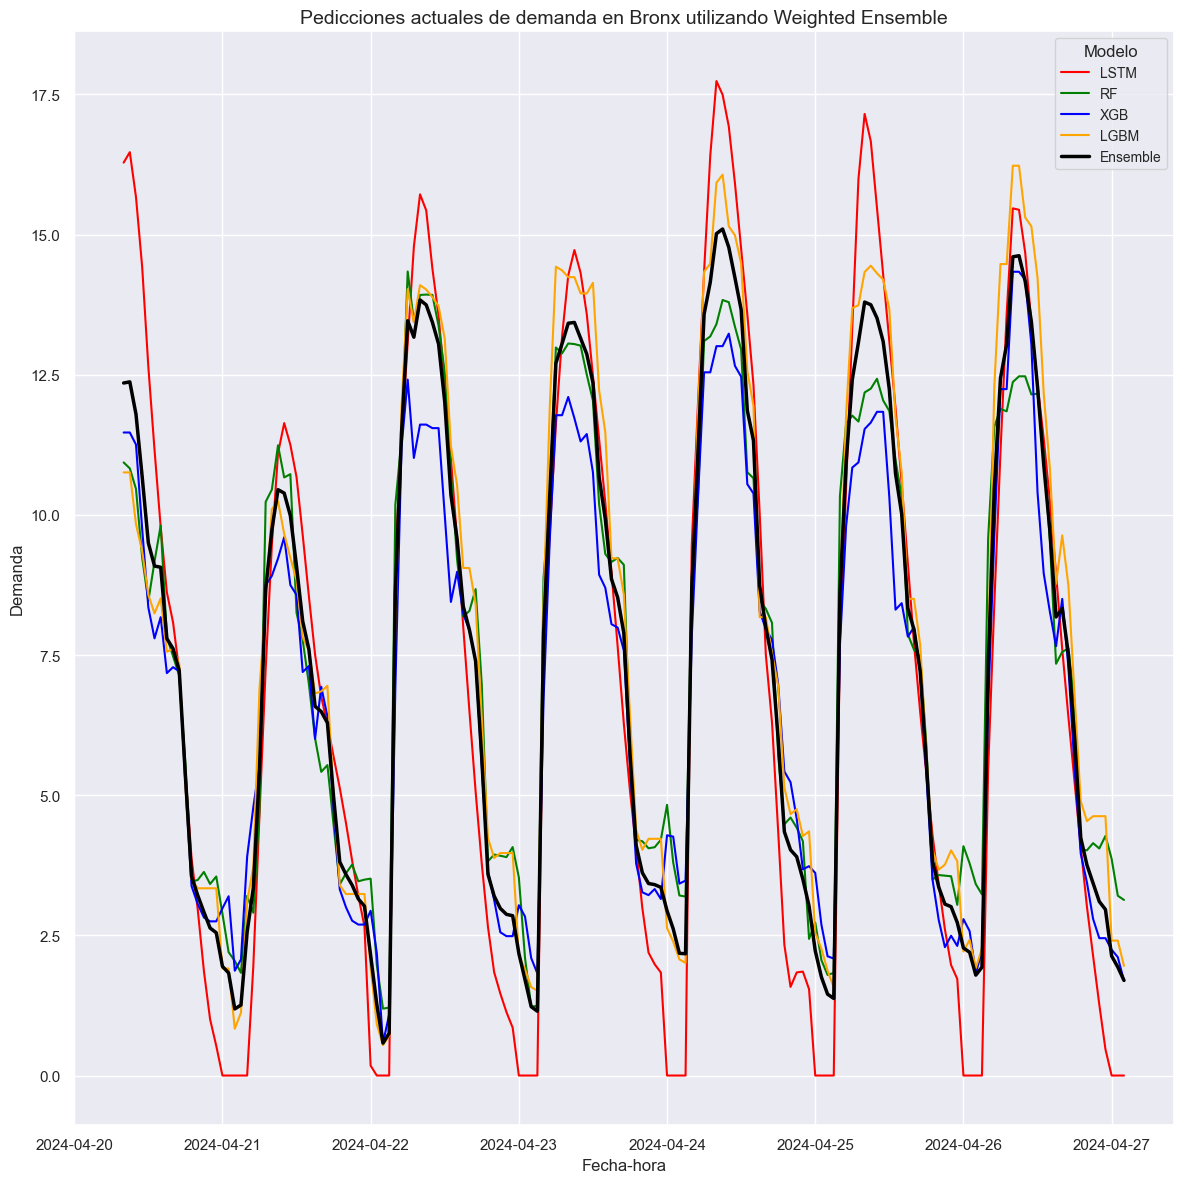

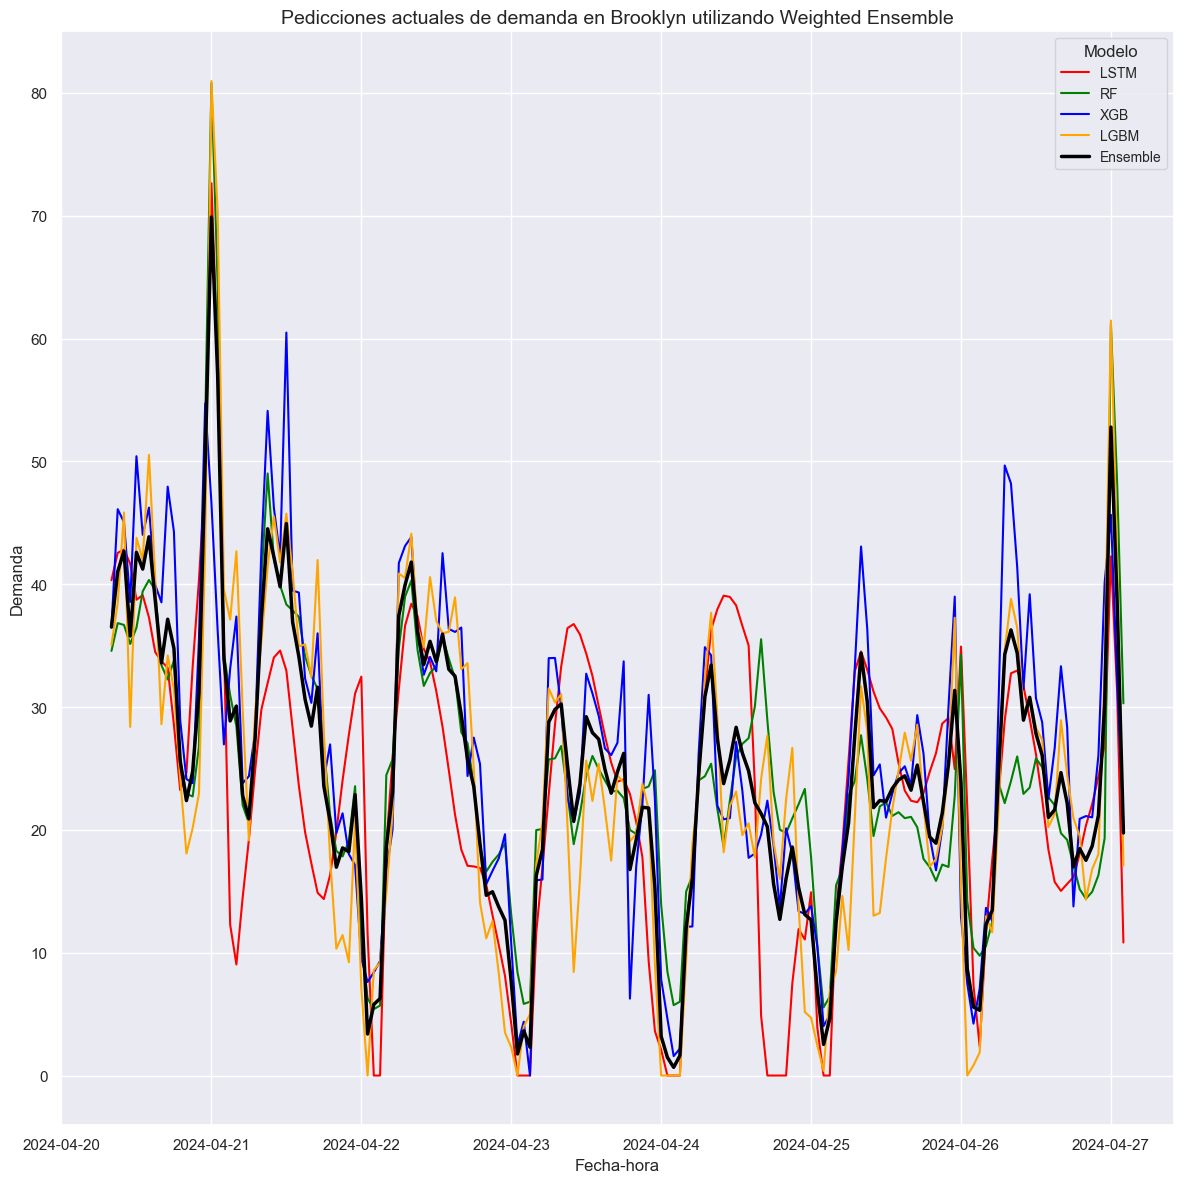

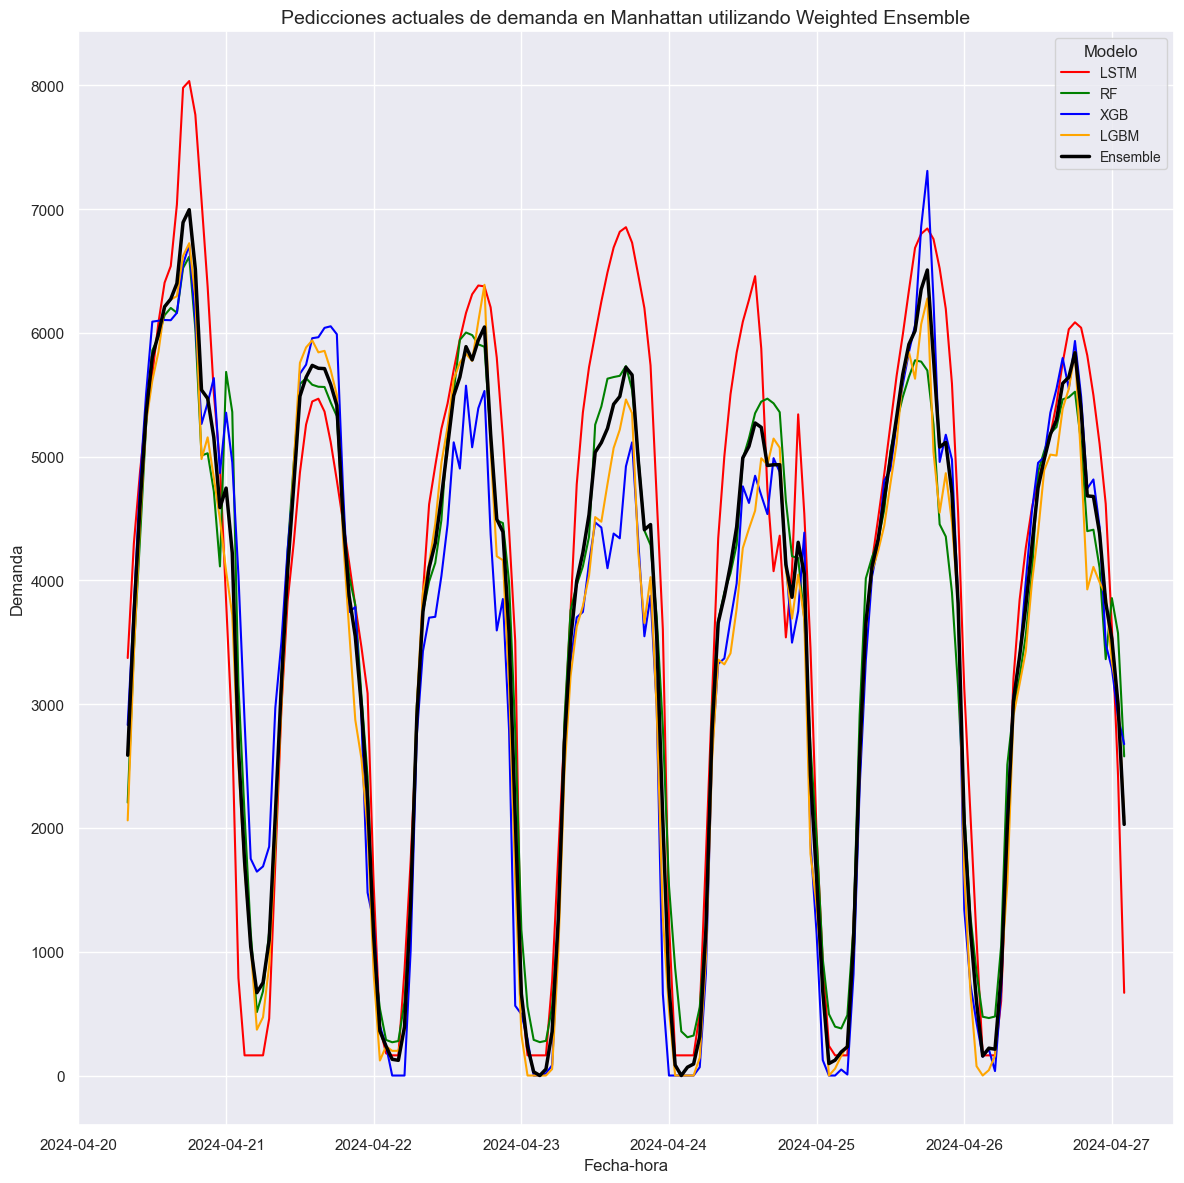

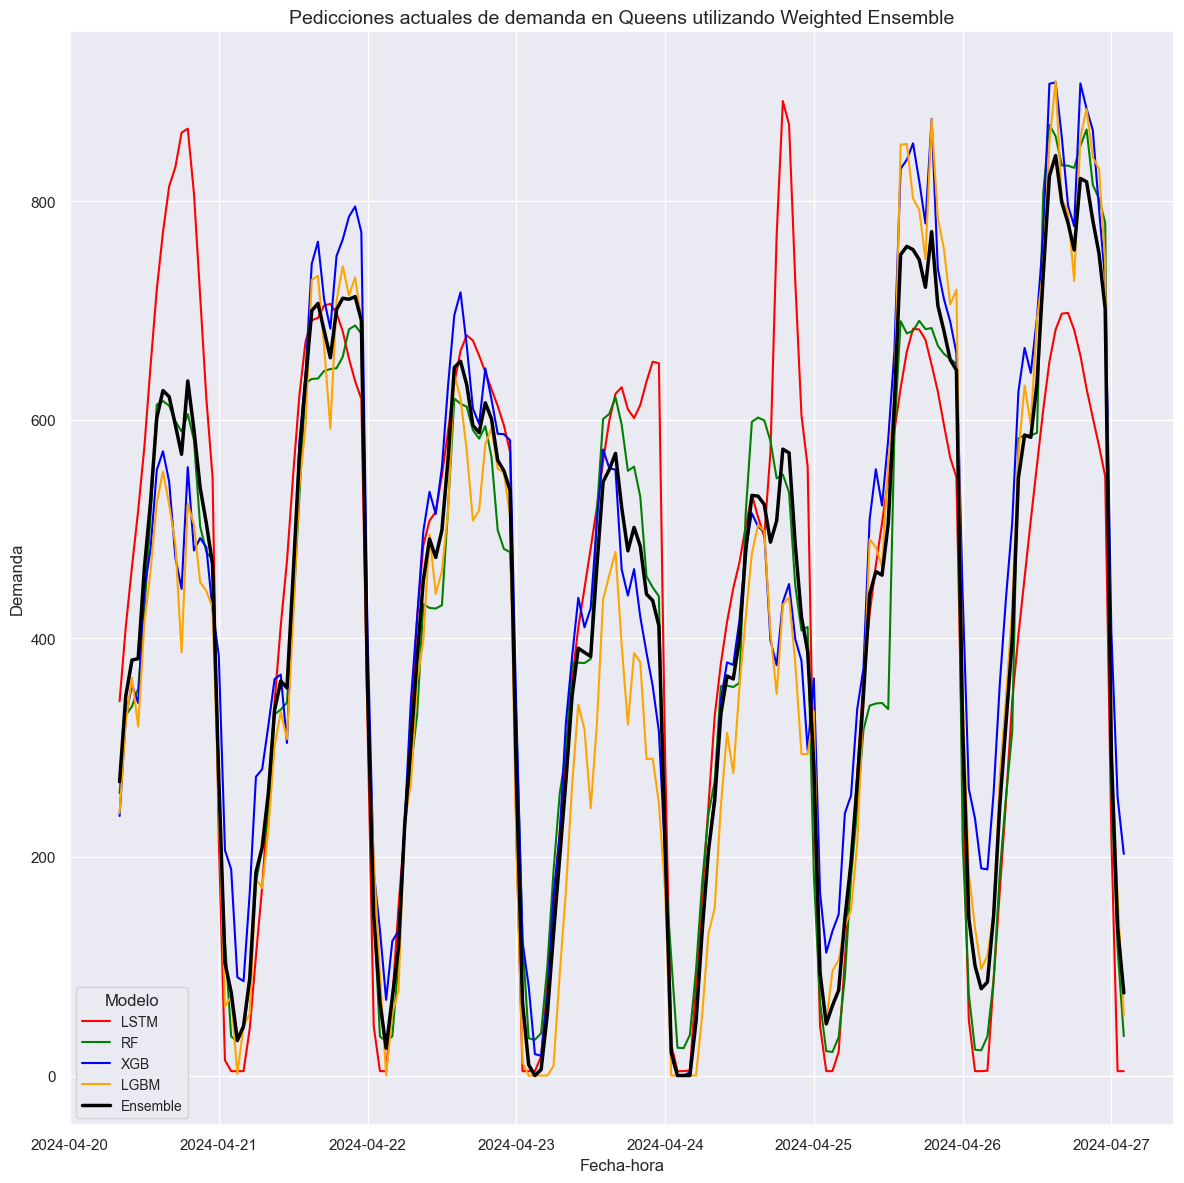

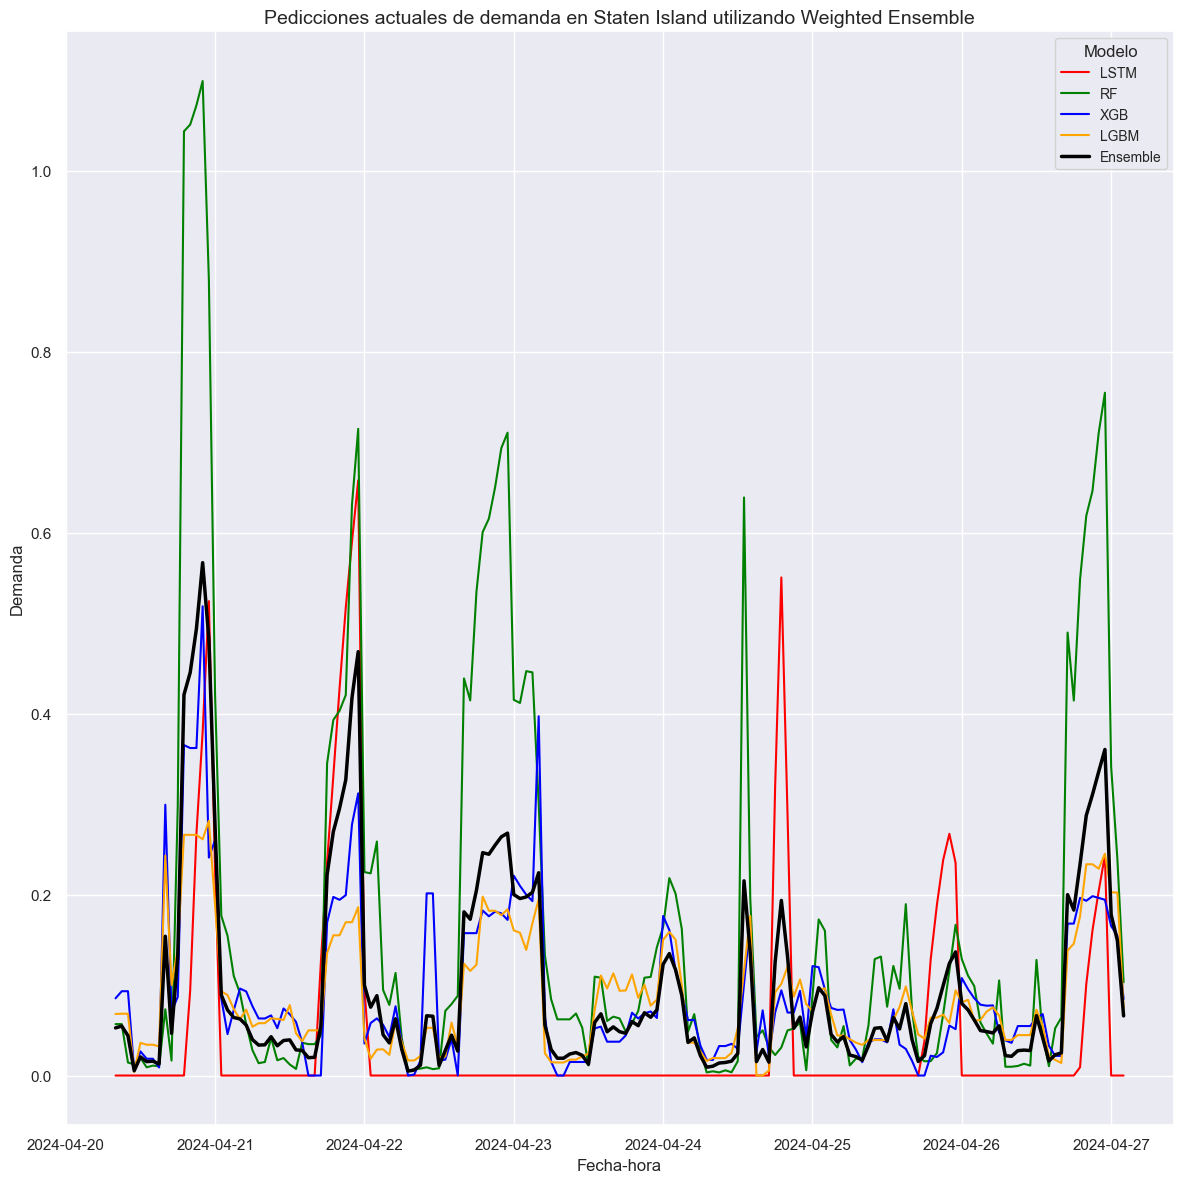

In [58]:
graficar_predicciones(pred)

Ahora vamos a definir una función para entrenar y testear el ensemble:

In [74]:
def train_test_ensemble(data, verbose=0, test_size=0.1, nro_pasos=5, exportar='si', file='ensemble.joblib', ensemble=None):
    
    if verbose==1 & ensemble==None:
        print('Comienzo del entrenamiento del ensemble')
    if verbose==1 & ensemble != None:
        print('Comienzo del testeo del ensemble')

    columnas_X = ['año', 'mes', 'dia', 'hora', 'dia_semana', 'holiday', 'temperature_2m', 'rain', 'relative_humidity_2m', 'snowfall']
    columnas_Y = ['Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island']
    
    train_data, test_data = train_test_split(data, test_size=test_size, shuffle=False)

    if ensemble == None:
        ensemble = generar_ensemble(train_data, exportar=exportar, file=file, p=nro_pasos, verbose=verbose)

    test_pred_ensemble = predecir(ensemble, test=True, test_data=test_data[columnas_X], verbose=verbose)

    ensemble_predictions = {}
    ensemble_errors = {}

    for district in columnas_Y:
        y_pred = test_pred_ensemble[district]['ensemble']
        y_test = test_data[district].iloc[nro_pasos-1:-1]
        
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)

        ensemble_errors[district] = {'MSE': mse, 'RMSE': rmse}

        if verbose==1:
            print('RMSE:', rmse)

        predictions_df = pd.DataFrame({
            'Predicted': y_pred,
            'Real values': y_test
        }, index=y_test.index)

        ensemble_predictions[district] = predictions_df
    
    if verbose==1 & ensemble ==None:
        print('Finalizado el entrenamiento del ensemble')
        print('Errores', ensemble_errors)

    if verbose==1 & ensemble !=None:
        print('Finalizado el testeo del ensemble')
        print('Errores', ensemble_errors)

    return ensemble, ensemble_predictions, ensemble_errors



In [75]:
def train_ensemble(data, verbose=0, test_size=0.1, nro_pasos=5, exportar='si', file='ensemble.joblib'):
    ensemble, ensemble_predictions, ensemble_errors = train_test_ensemble(data=data, verbose=verbose, test_size=test_size,
                                                                            nro_pasos=nro_pasos, exportar=exportar, file=file)
    return ensemble, ensemble_predictions, ensemble_errors

In [76]:
def test_ensemble(data, ensemble, verbose=0, test_size=0.1, nro_pasos=5, exportar='si', file='ensemble.joblib'):
    ensemble, ensemble_predictions, ensemble_errors = train_test_ensemble(data=data, verbose=verbose, test_size=test_size,
                                                                            nro_pasos=nro_pasos, exportar=exportar, file=file, ensemble=ensemble)
    return ensemble, ensemble_predictions, ensemble_errors

In [77]:
ensemble, ensemble_predictions, ensemble_errors = test_ensemble(df, ensemble)

In [78]:
ensemble_errors

{'Bronx': {'MSE': 29.58021871962645, 'RMSE': 5.43876996384536},
 'Brooklyn': {'MSE': 348.60888051875907, 'RMSE': 18.671070684852516},
 'Manhattan': {'MSE': 2056935.9630112816, 'RMSE': 1434.2022043670418},
 'Queens': {'MSE': 15707.202180536096, 'RMSE': 125.32837739528944},
 'Staten Island': {'MSE': 0.055535819330419, 'RMSE': 0.23566038982064635}}

In [79]:
ensemble_predictions['Manhattan']

Predicted  Real values
datetime                                     
2023-12-26 01:00:00   549.126237          289
2023-12-26 02:00:00   298.986346          186
2023-12-26 03:00:00   198.670500          134
2023-12-26 04:00:00   197.324705          164
2023-12-26 05:00:00   333.013766          291
...                          ...          ...
2023-12-31 18:00:00  6065.328806         3938
2023-12-31 19:00:00  5268.386411         4513
2023-12-31 20:00:00  4701.837078         4728
2023-12-31 21:00:00  4575.968980         4531
2023-12-31 22:00:00  3885.583671         4033

[142 rows x 2 columns]